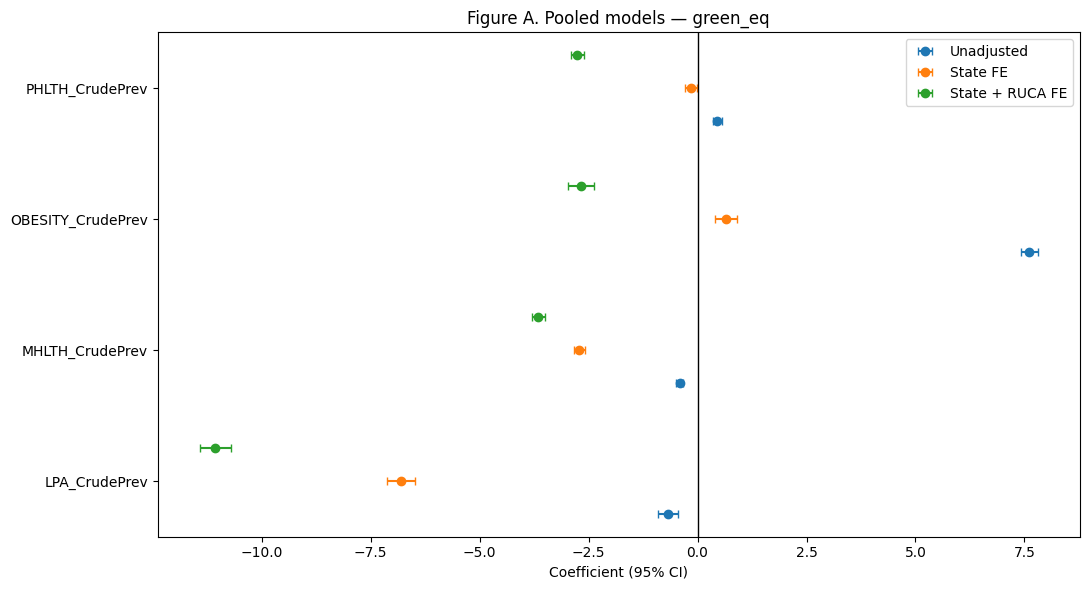

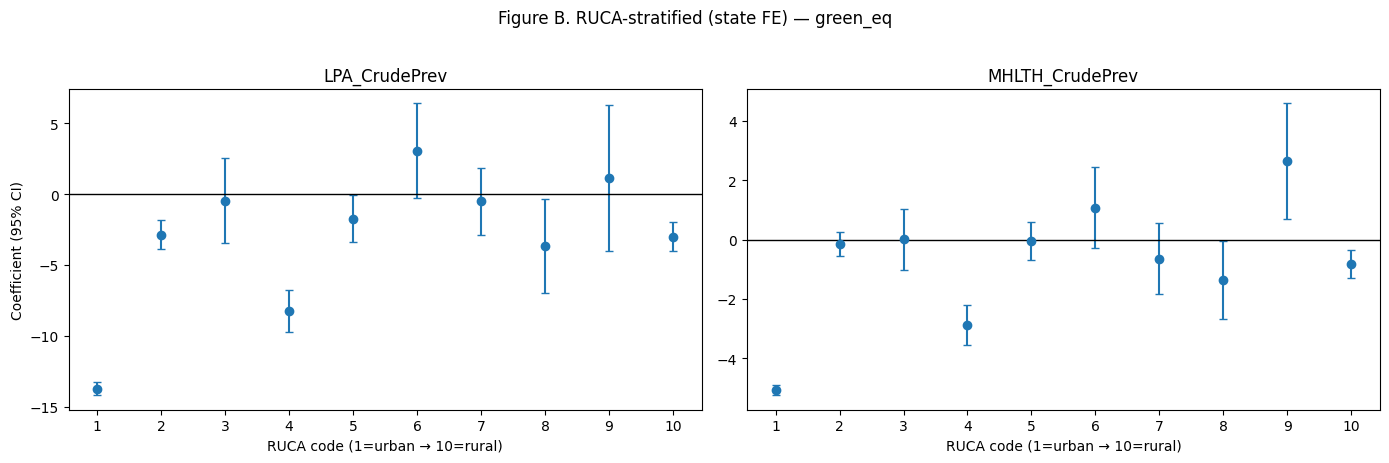

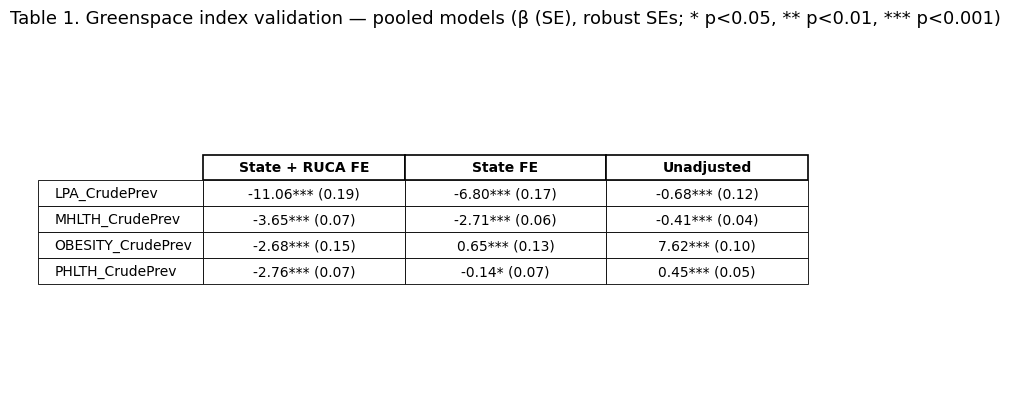

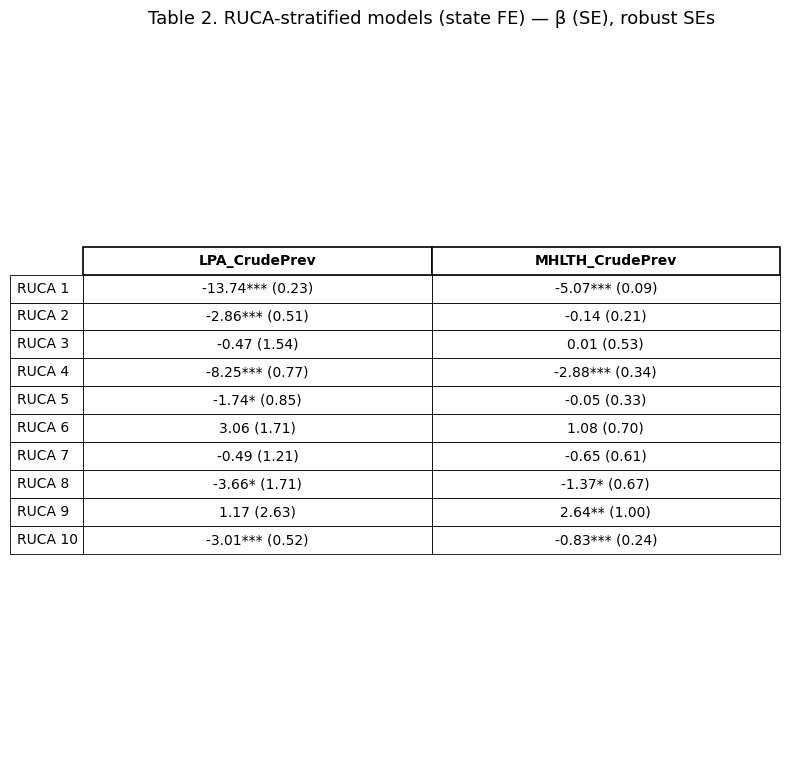

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_FILE = "/mnt/sda-21.8/bdevoe/greenspace/processed/index_validation/places_validation_results_with_ruca.csv"

# -------------------------
# Settings
# -------------------------
INDEX_MAIN = "green_eq"

OUTCOMES_MAIN = ["LPA_CrudePrev", "MHLTH_CrudePrev", "OBESITY_CrudePrev", "PHLTH_CrudePrev"]
OUTCOMES_RUCA = ["LPA_CrudePrev", "MHLTH_CrudePrev"]

POOLED_MODELS = ["pooled_unadjusted", "pooled_stateFE", "pooled_stateFE_rucaFE"]
POOLED_MODEL_LABELS = {
    "pooled_unadjusted": "Unadjusted",
    "pooled_stateFE": "State FE",
    "pooled_stateFE_rucaFE": "State + RUCA FE",
}

STRAT_MODEL = "ruca_strat_stateFE"

# Set True if you want PNG images you can paste into slides/docs
SAVE_IMAGES = False
OUT_DIR = "/mnt/sda-21.8/bdevoe/greenspace/figures/index_validation"
TABLE1_PNG = f"{OUT_DIR}/Table_main_models_green_eq.png"
TABLE2_PNG = f"{OUT_DIR}/Table_ruca_strat_green_eq.png"


# -------------------------
# Helpers
# -------------------------
def add_ci(d):
    d = d.copy()
    d["ci_low"] = d["estimate"] - 1.96 * d["std_error"]
    d["ci_high"] = d["estimate"] + 1.96 * d["std_error"]
    return d

def p_to_stars(p):
    if pd.isna(p): return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

def fmt_cell(beta, se, p):
    if pd.isna(beta) or pd.isna(se):
        return ""
    return f"{beta:.2f}{p_to_stars(p)} ({se:.2f})"

def render_table_as_figure(table_df, title, save_path=None):
    """
    Render a pandas dataframe as a clean matplotlib figure table.
    """
    fig, ax = plt.subplots(figsize=(max(8, 1.2*len(table_df.columns)), 0.6*len(table_df) + 1.8))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=12)

    tbl = ax.table(
        cellText=table_df.values,
        colLabels=table_df.columns,
        rowLabels=table_df.index,
        cellLoc="center",
        loc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1, 1.4)

    # Light styling
    for (r, c), cell in tbl.get_celld().items():
        cell.set_linewidth(0.6)
        if r == 0:  # header row
            cell.set_linewidth(1.2)
            cell.set_text_props(weight="bold")

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=250, bbox_inches="tight")
        print("Saved table image:", save_path)
    plt.show()
    plt.close(fig)


# -------------------------
# Load results
# -------------------------
df = pd.read_csv(RESULTS_FILE)

# ============================================================
# FIGURE A: pooled model coefficient plot — green_eq
# ============================================================
dA = df[
    (df["index"] == INDEX_MAIN) &
    (df["model"].isin(POOLED_MODELS)) &
    (df["outcome"].isin(OUTCOMES_MAIN))
].copy()

dA = add_ci(dA)
dA["model"] = pd.Categorical(dA["model"], POOLED_MODELS, ordered=True)

fig, ax = plt.subplots(figsize=(11, 6))
y_map = {o: i for i, o in enumerate(OUTCOMES_MAIN)}
offsets = np.linspace(-0.25, 0.25, len(POOLED_MODELS))

for j, m in enumerate(POOLED_MODELS):
    dm = dA[dA["model"] == m]
    if dm.empty:
        continue
    y = np.array([y_map[o] for o in dm["outcome"]]) + offsets[j]
    ax.errorbar(
        dm["estimate"],
        y,
        xerr=[dm["estimate"] - dm["ci_low"], dm["ci_high"] - dm["estimate"]],
        fmt="o",
        capsize=3,
        label=POOLED_MODEL_LABELS.get(m, m)
    )

ax.axvline(0, color="black", linewidth=1)
ax.set_yticks(list(y_map.values()))
ax.set_yticklabels(OUTCOMES_MAIN)
ax.set_xlabel("Coefficient (95% CI)")
ax.set_title(f"Figure A. Pooled models — {INDEX_MAIN}")
ax.legend()
plt.tight_layout()
plt.show()
plt.close(fig)

# ============================================================
# FIGURE B: RUCA-stratified coefficients (state FE) — green_eq
#          Two panels: LPA + MHLTH
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5), sharey=False)

for ax, outcome in zip(axes, OUTCOMES_RUCA):
    dB = df[
        (df["index"] == INDEX_MAIN) &
        (df["model"] == STRAT_MODEL) &
        (df["outcome"] == outcome)
    ].copy()
    dB = add_ci(dB)
    dB = dB.dropna(subset=["ruca_level"]).copy()
    dB["ruca_level"] = dB["ruca_level"].astype(int)
    dB = dB.sort_values("ruca_level")

    ax.errorbar(
        dB["ruca_level"],
        dB["estimate"],
        yerr=[dB["estimate"] - dB["ci_low"], dB["ci_high"] - dB["estimate"]],
        fmt="o",
        capsize=3
    )
    ax.axhline(0, color="black", linewidth=1)
    ax.set_xticks(range(1, 11))
    ax.set_xlabel("RUCA code (1=urban → 10=rural)")
    ax.set_title(outcome)

axes[0].set_ylabel("Coefficient (95% CI)")
fig.suptitle(f"Figure B. RUCA-stratified (state FE) — {INDEX_MAIN}", y=1.02)
plt.tight_layout()
plt.show()
plt.close(fig)

# ============================================================
# TABLE 1: Professional pooled-model table (green_eq)
# Rows = outcomes; Cols = models; Cells = beta (SE) + stars
# ============================================================
tab1 = df[
    (df["index"] == INDEX_MAIN) &
    (df["model"].isin(POOLED_MODELS)) &
    (df["outcome"].isin(OUTCOMES_MAIN))
].copy()

tab1["model_label"] = tab1["model"].map(POOLED_MODEL_LABELS)
tab1["cell"] = tab1.apply(lambda r: fmt_cell(r["estimate"], r["std_error"], r["p"]), axis=1)

# N and R2 are basically constant per outcome+model here; we’ll keep them separately if you want.
tab1_pivot = tab1.pivot(index="outcome", columns="model_label", values="cell")
tab1_pivot = tab1_pivot.loc[OUTCOMES_MAIN]  # preserve order

render_table_as_figure(
    tab1_pivot,
    title="Table 1. Greenspace index validation — pooled models (β (SE), robust SEs; * p<0.05, ** p<0.01, *** p<0.001)",
    save_path=TABLE1_PNG if SAVE_IMAGES else None
)

# ============================================================
# TABLE 2: RUCA-stratified table for LPA + MHLTH (green_eq)
# Rows = RUCA; Cols = outcomes; Cells = beta (SE) + stars
# ============================================================
tab2 = df[
    (df["index"] == INDEX_MAIN) &
    (df["model"] == STRAT_MODEL) &
    (df["outcome"].isin(OUTCOMES_RUCA))
].copy()

tab2 = tab2.dropna(subset=["ruca_level"]).copy()
tab2["ruca_level"] = tab2["ruca_level"].astype(int)
tab2["cell"] = tab2.apply(lambda r: fmt_cell(r["estimate"], r["std_error"], r["p"]), axis=1)

tab2_pivot = tab2.pivot(index="ruca_level", columns="outcome", values="cell").sort_index()
tab2_pivot.index = [f"RUCA {i}" for i in tab2_pivot.index]

render_table_as_figure(
    tab2_pivot,
    title="Table 2. RUCA-stratified models (state FE) — β (SE), robust SEs",
    save_path=TABLE2_PNG if SAVE_IMAGES else None
)


Loaded results rows: 468
Detected indices: 9
Example indices: ['green_eq', 'green_nlcd_balanced_canopy', 'green_nlcd_bio_dominant', 'green_nlcd_canopy_weighted', 'green_nlcd_conservative', 'green_nlcd_eq_expanded', 'green_nlcd_nlcd_dominant', 'green_nlcd_vi_weighted', 'green_pca_pc1']


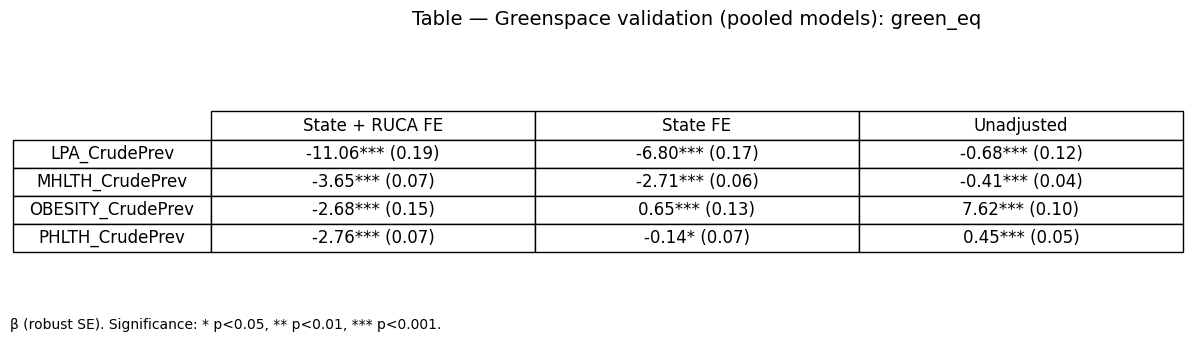

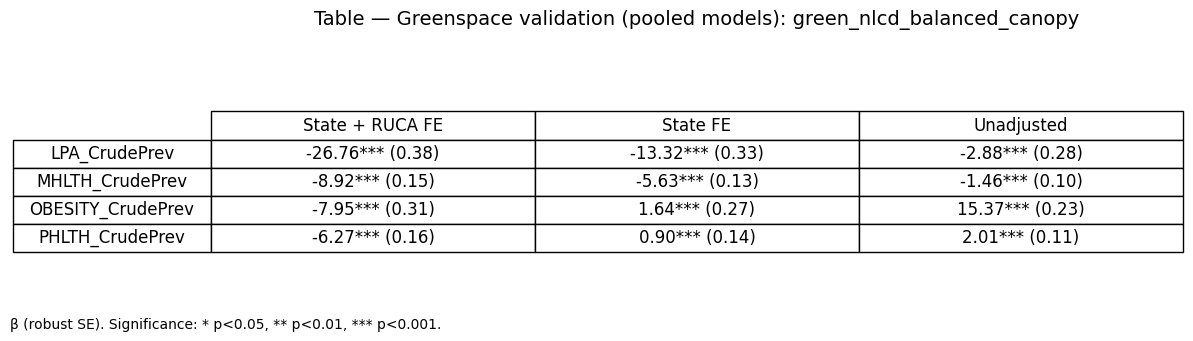

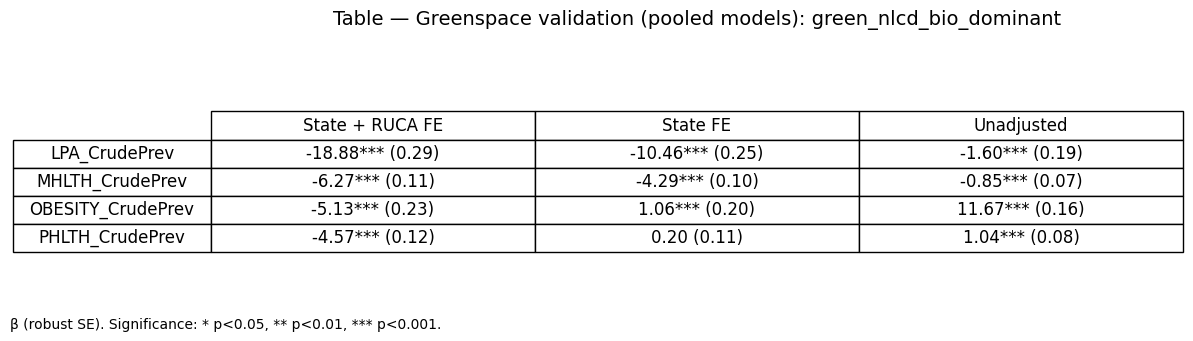

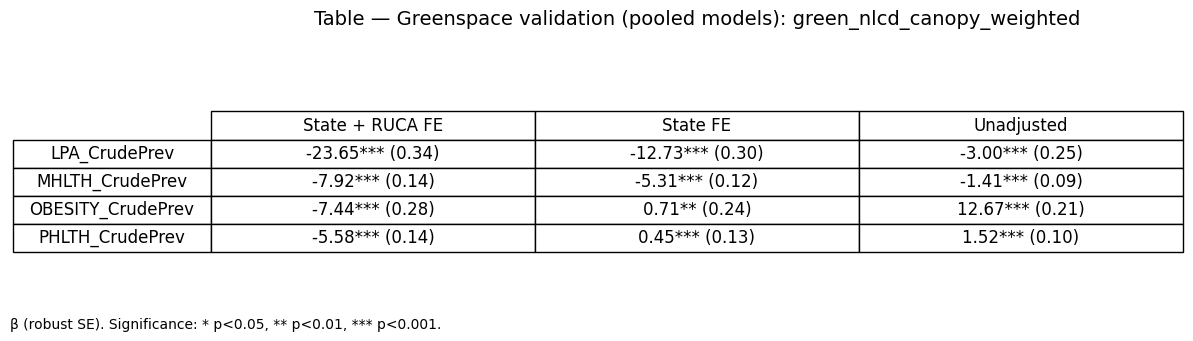

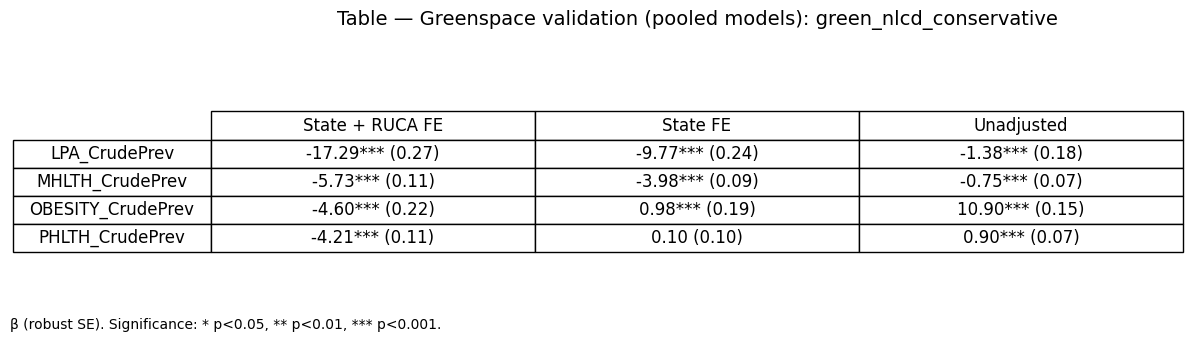

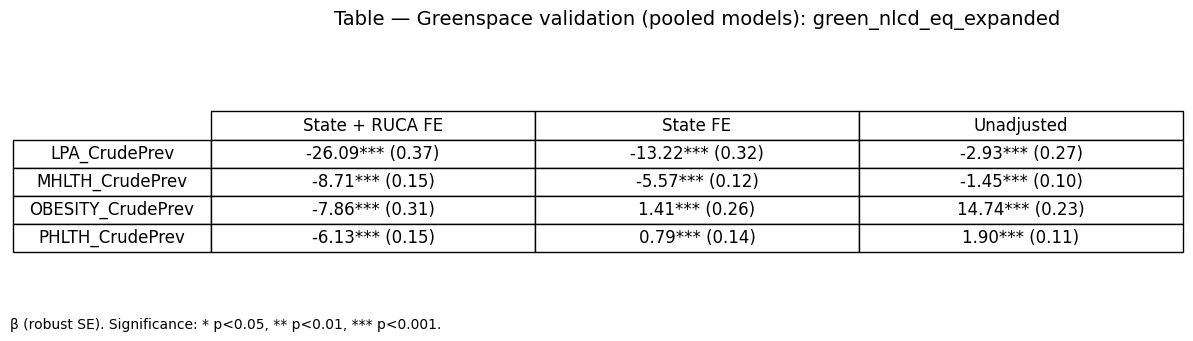

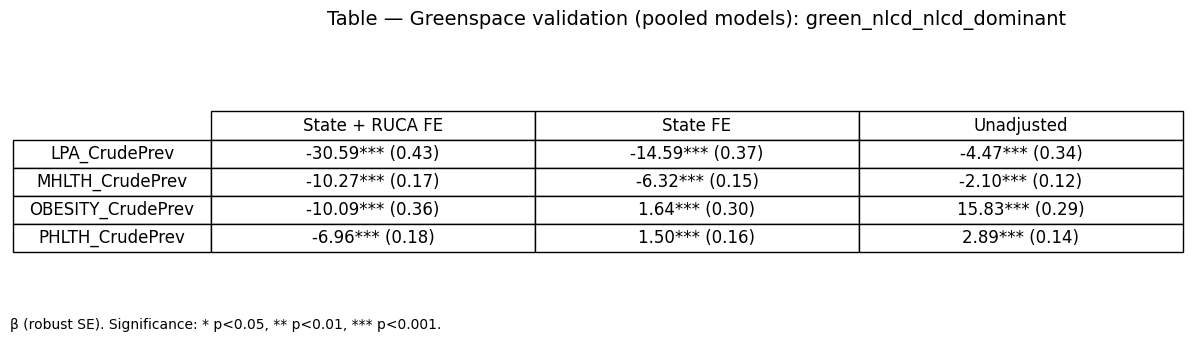

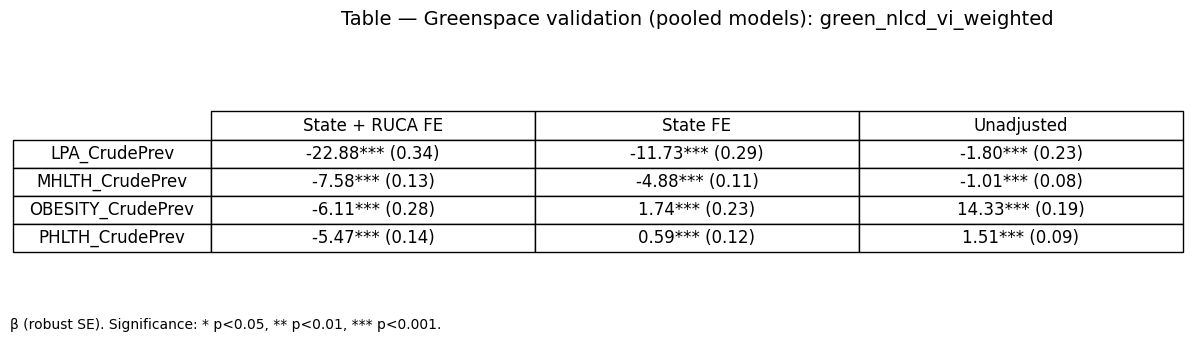

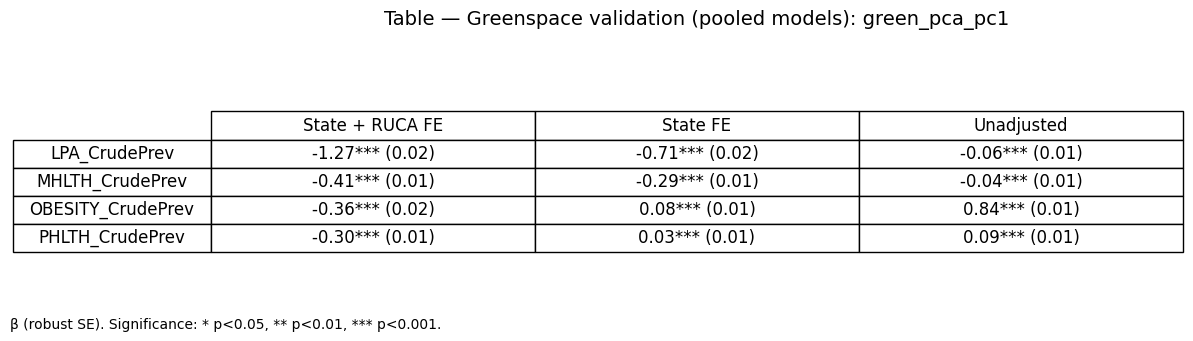

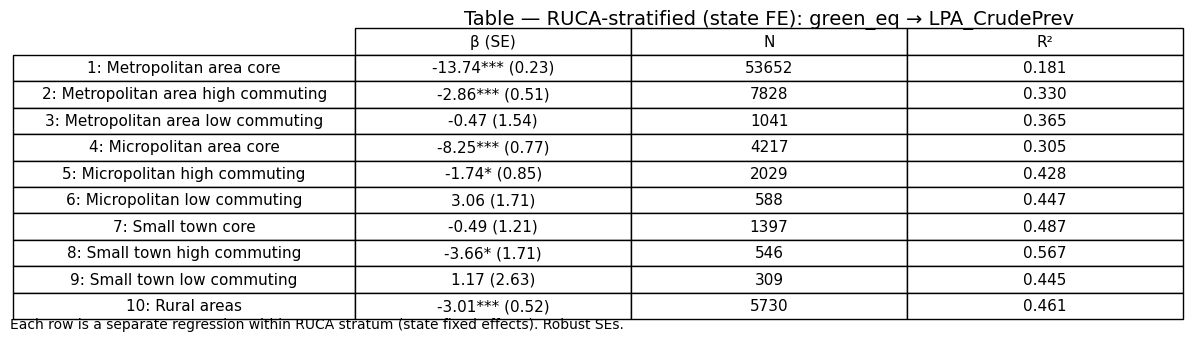

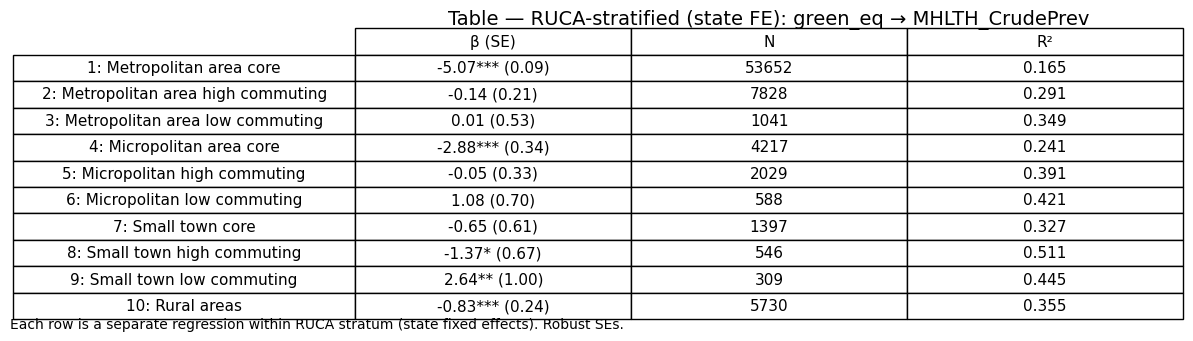

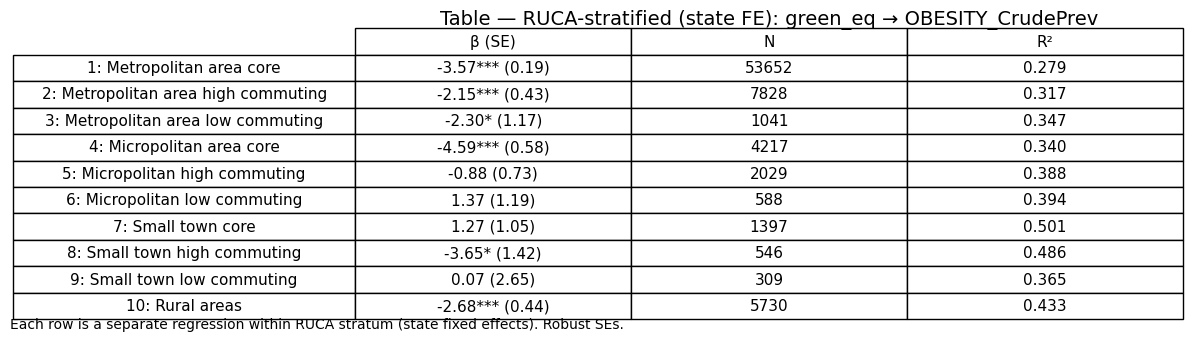

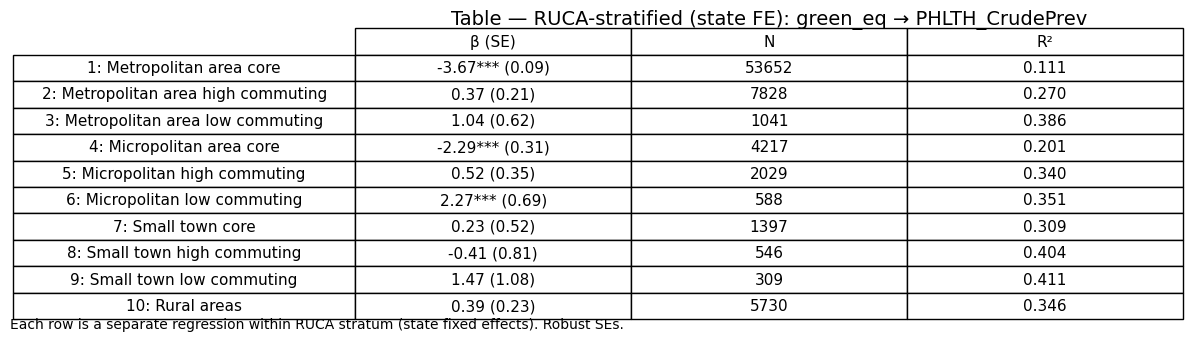

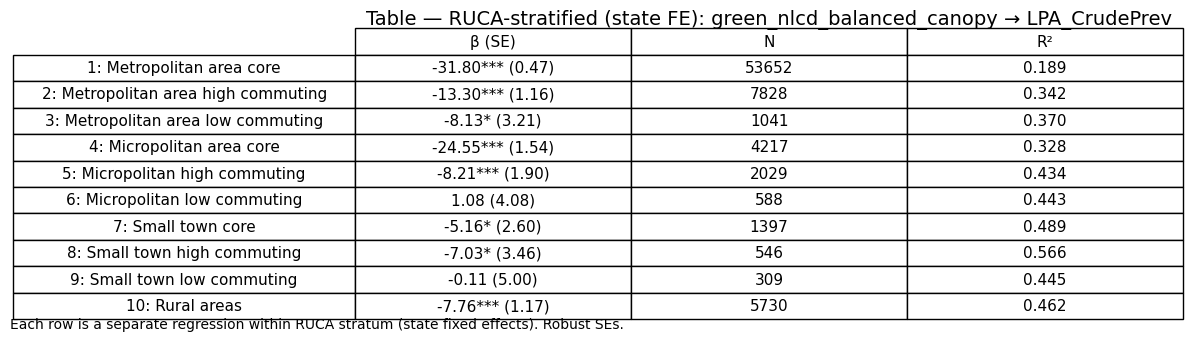

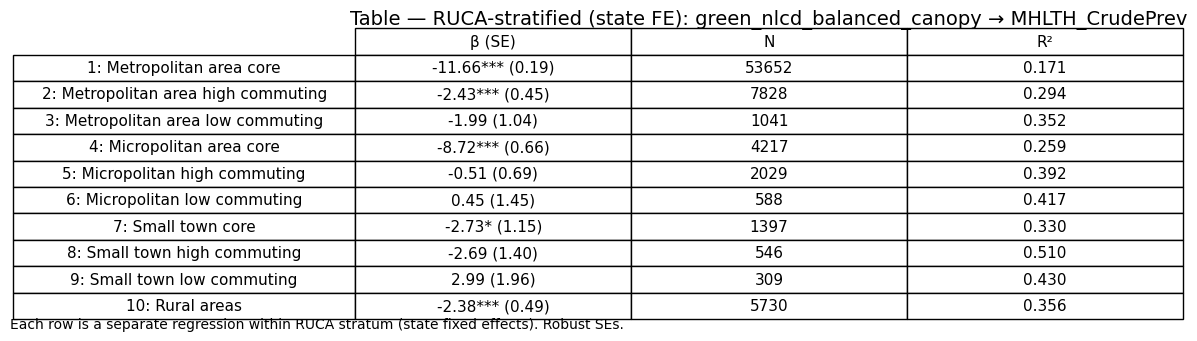

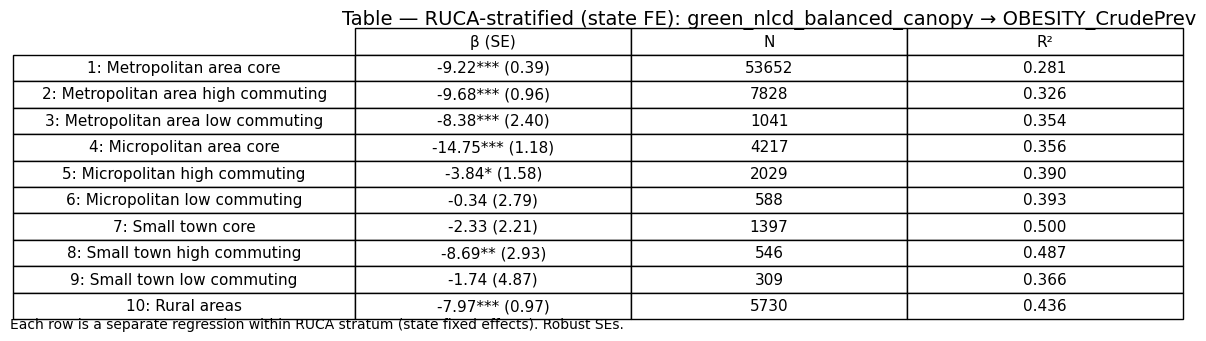

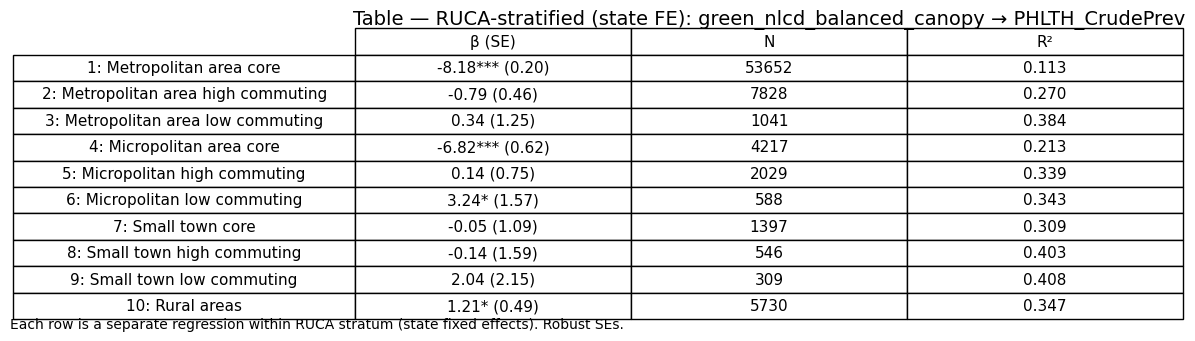

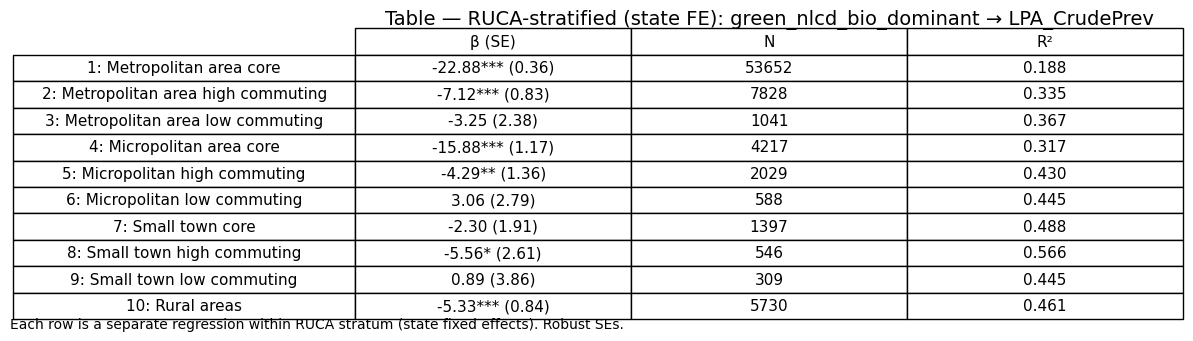

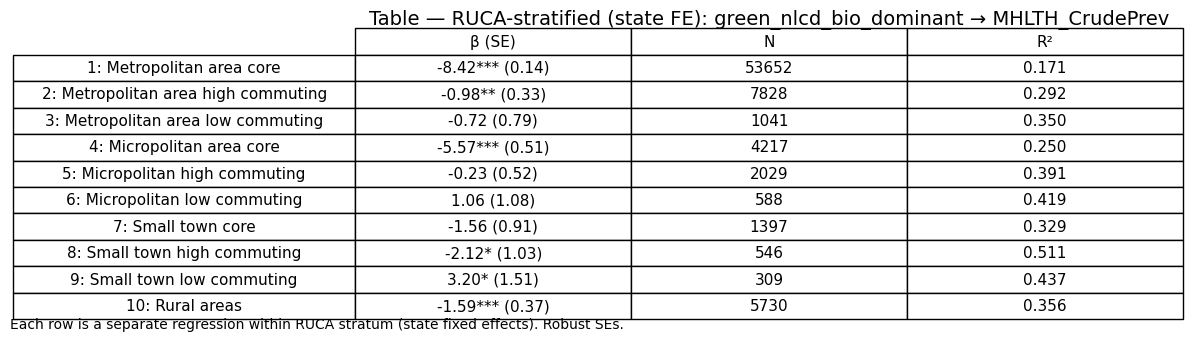

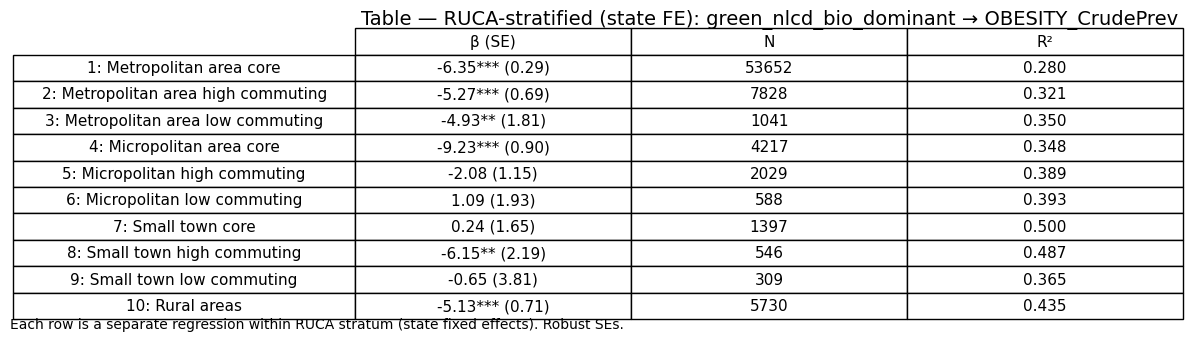

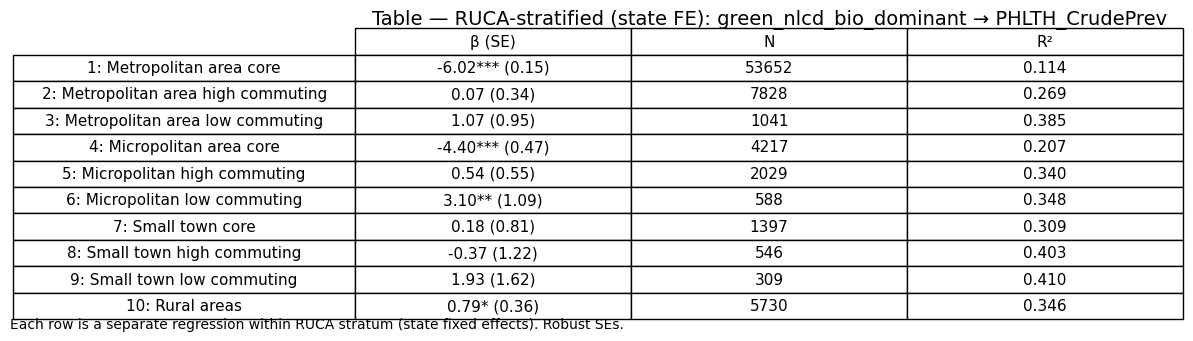

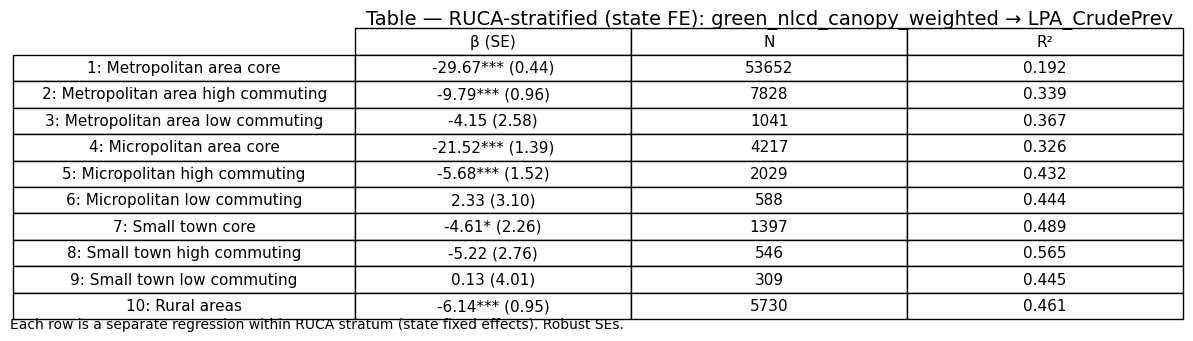

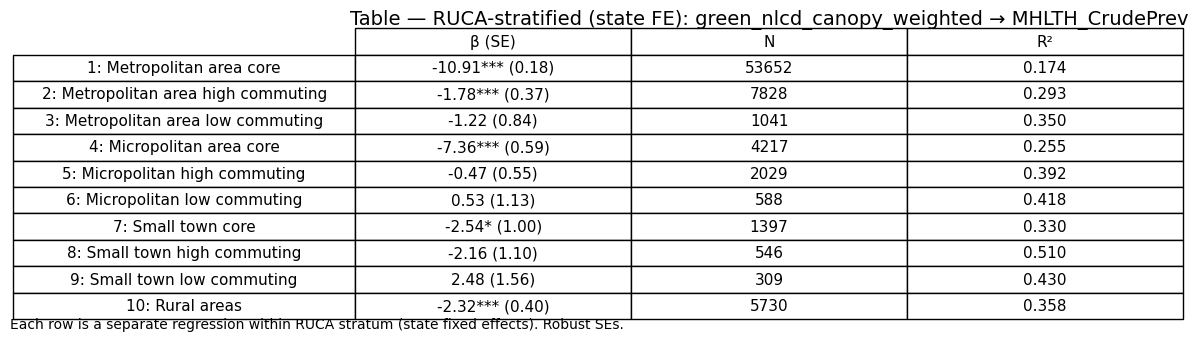

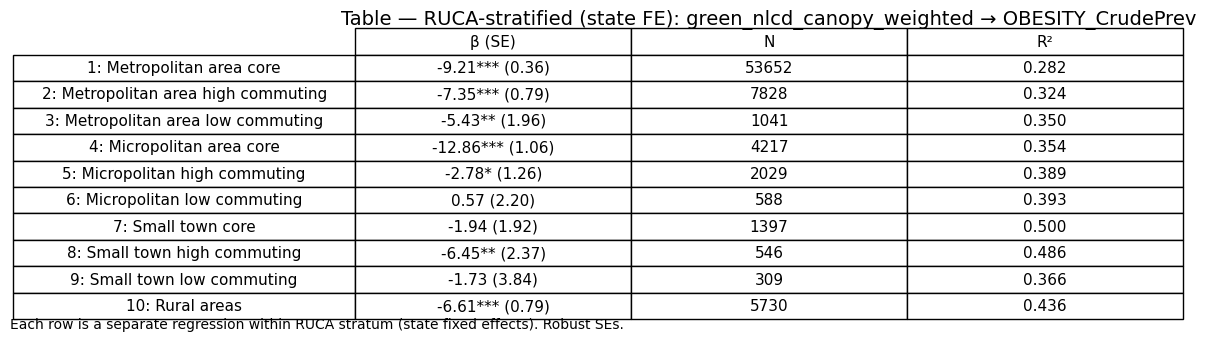

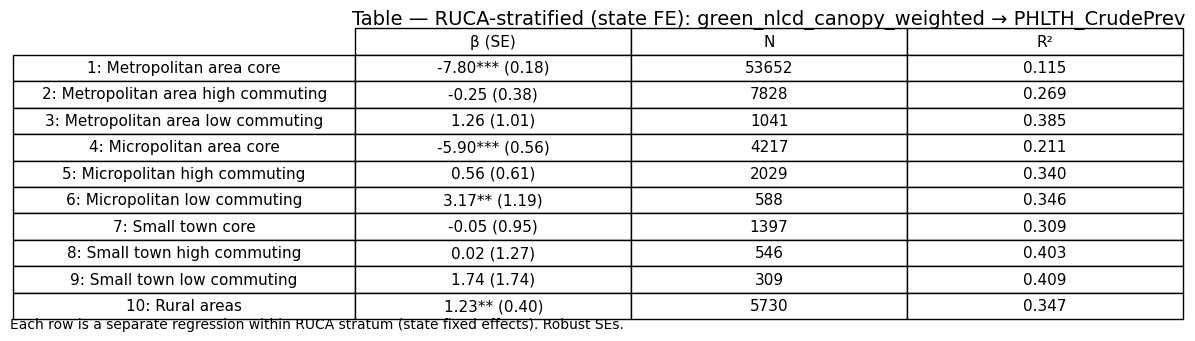

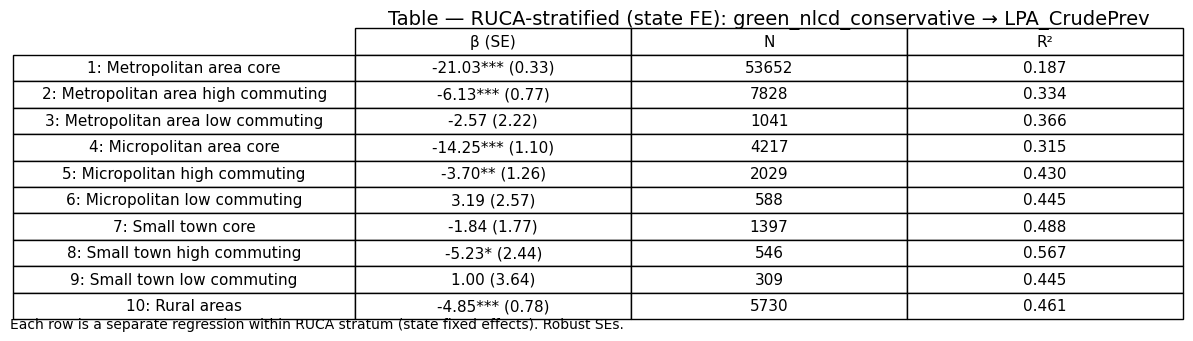

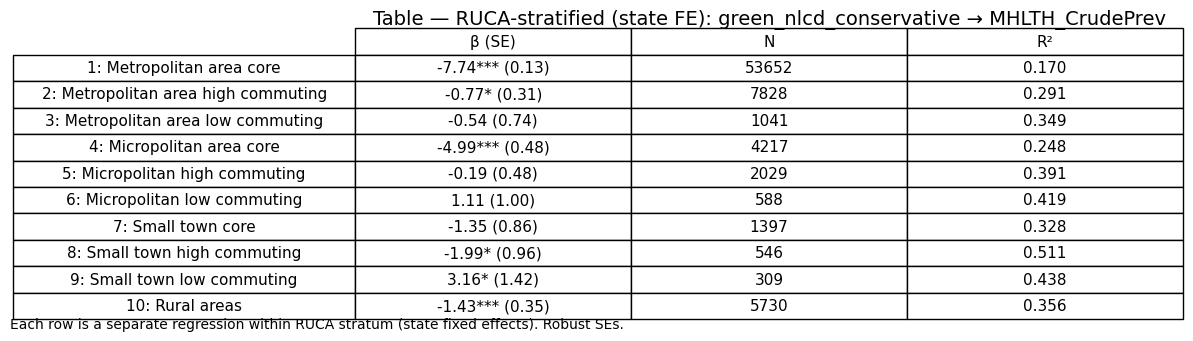

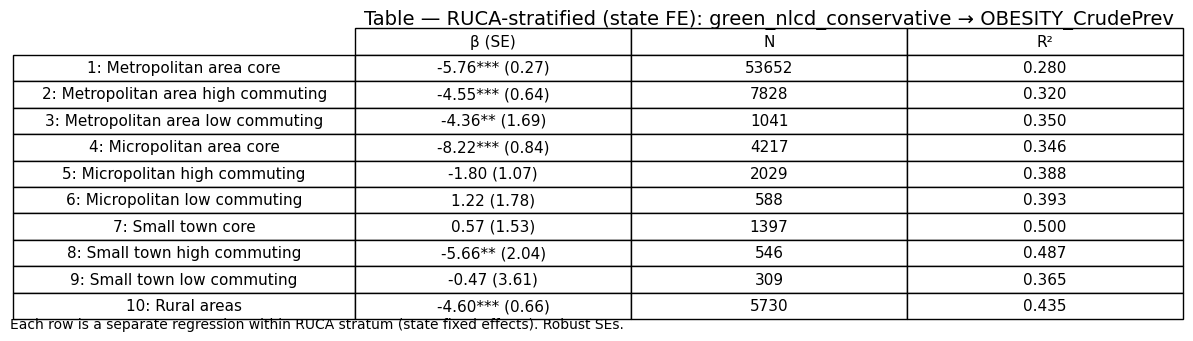

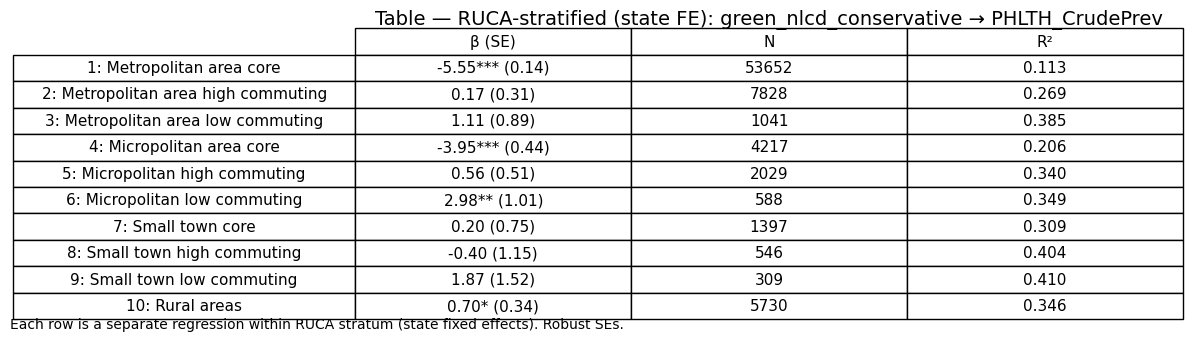

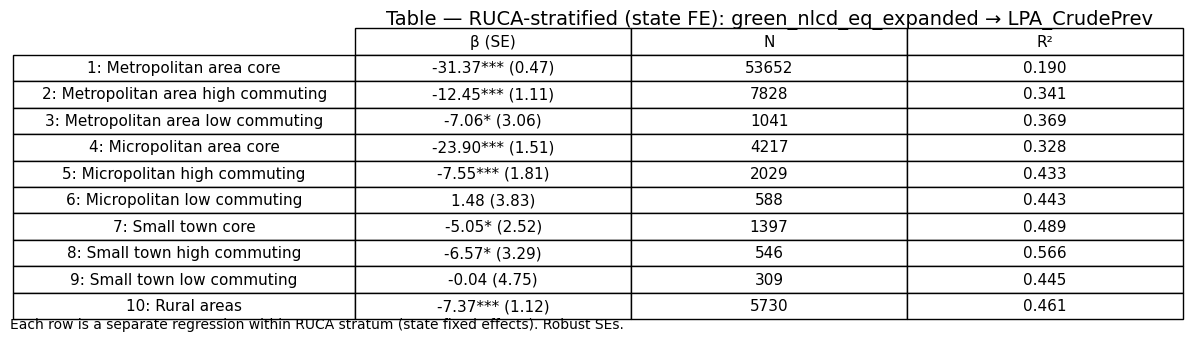

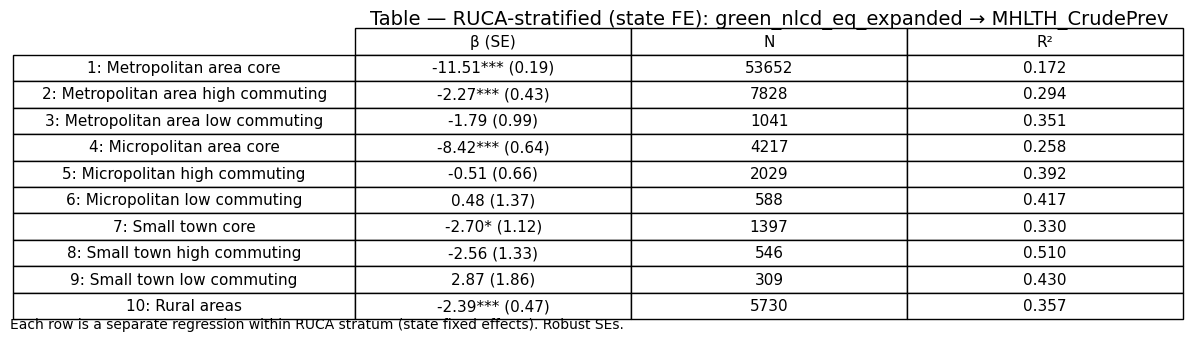

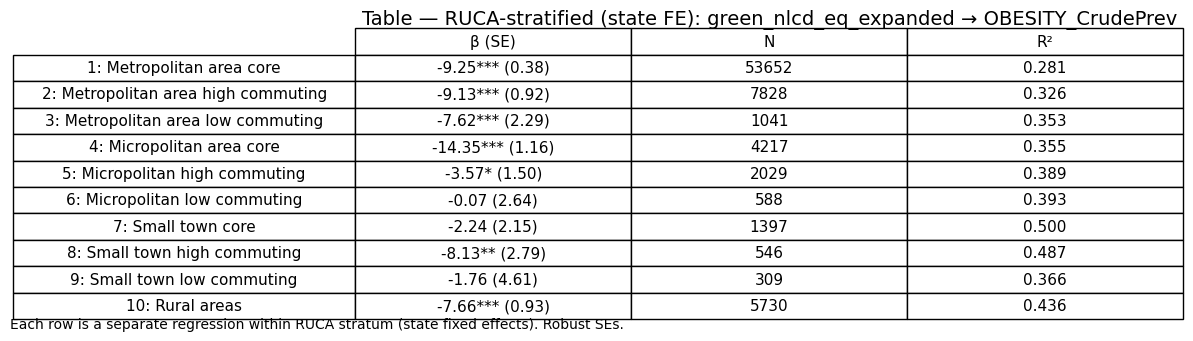

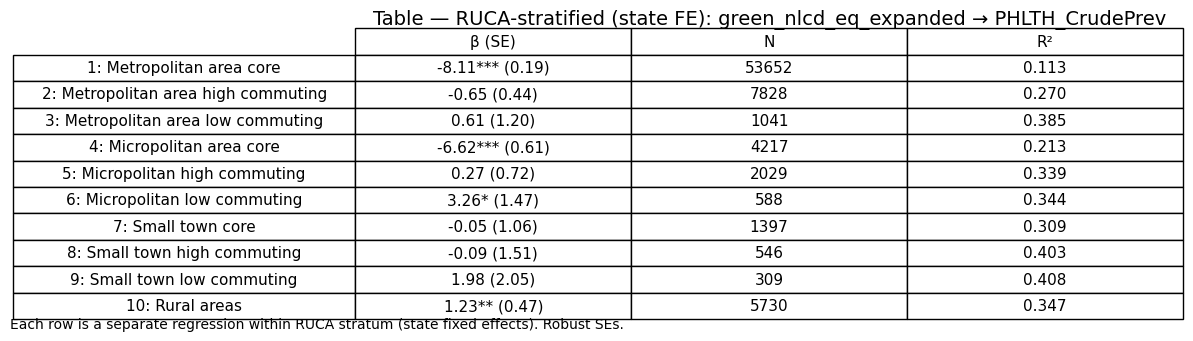

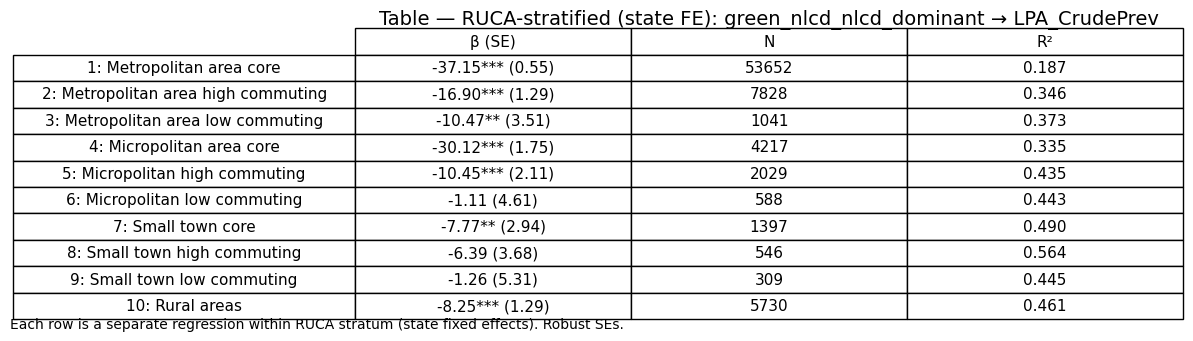

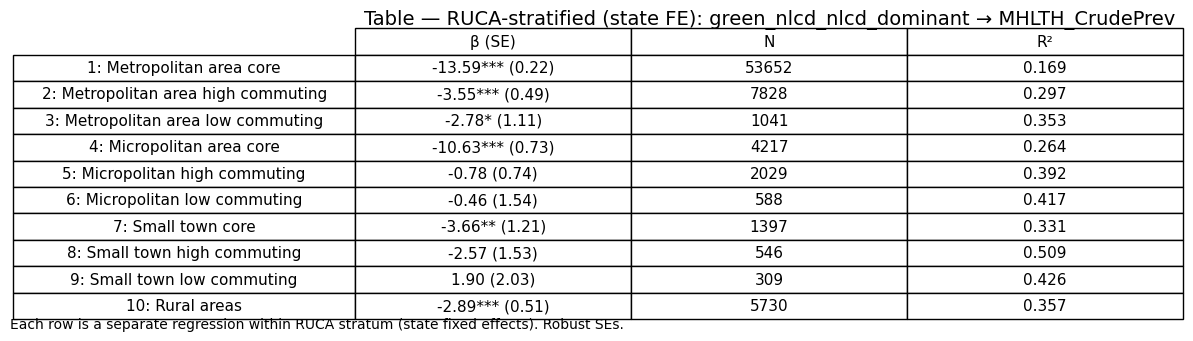

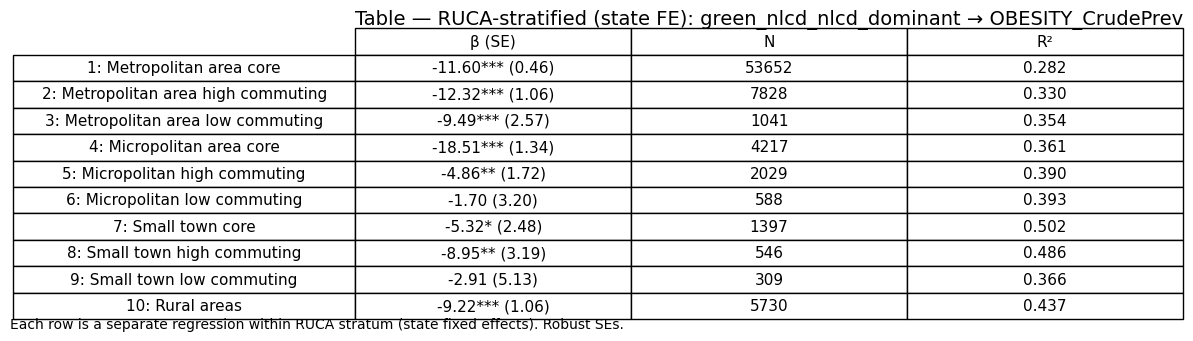

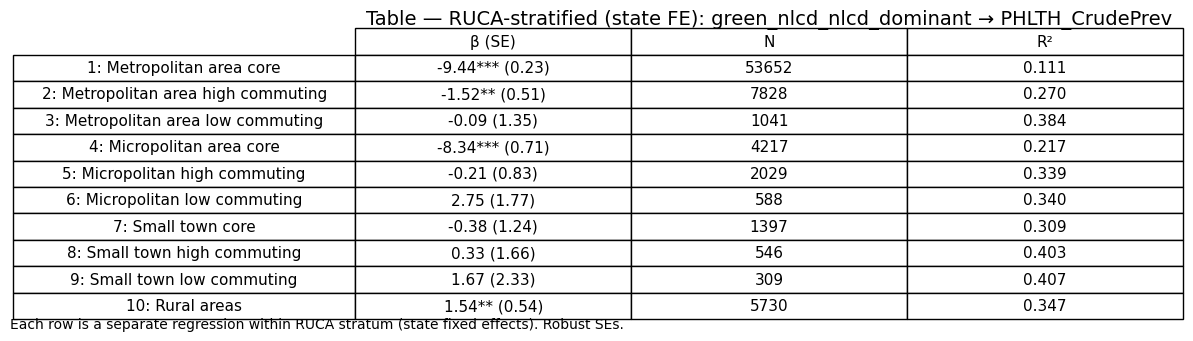

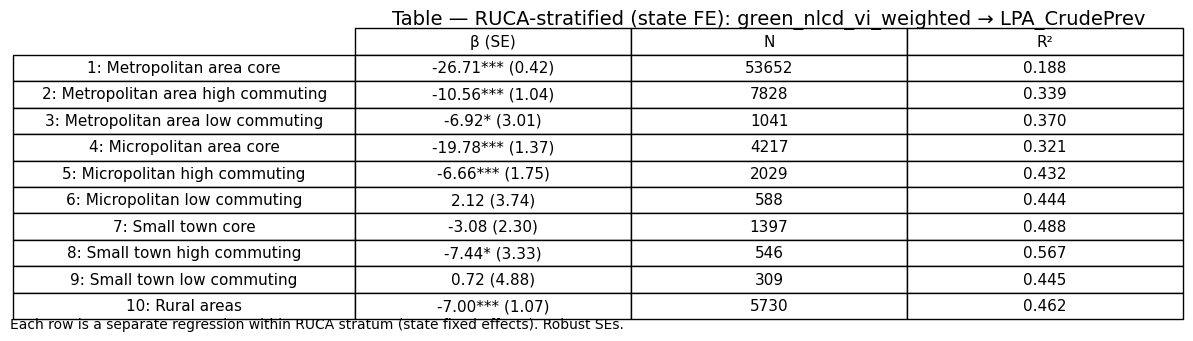

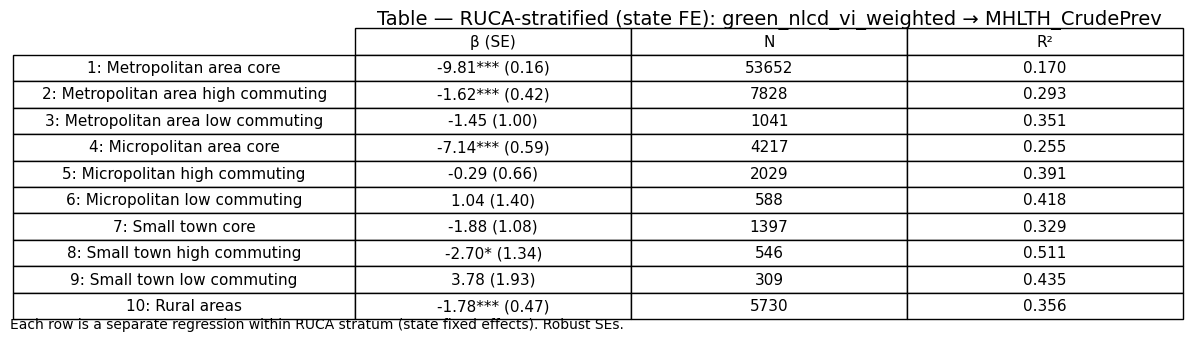

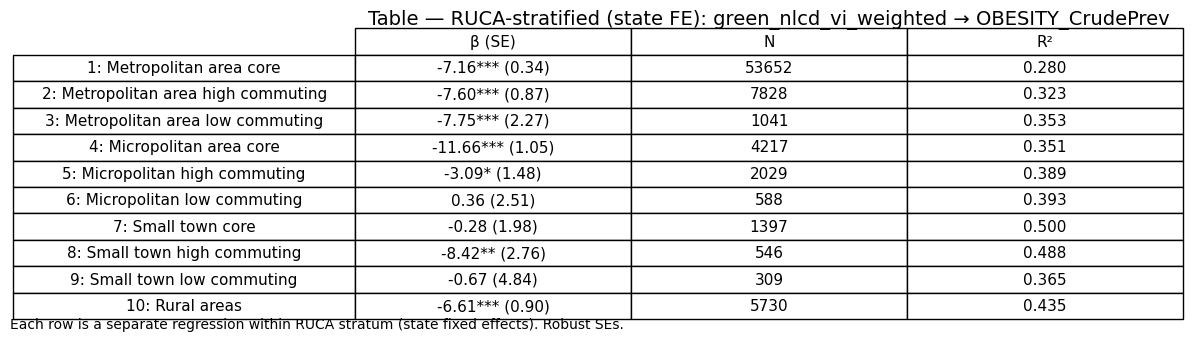

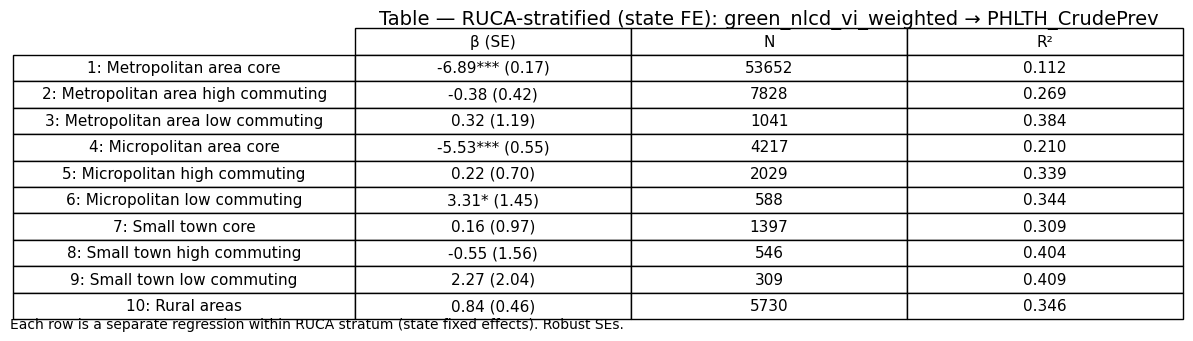

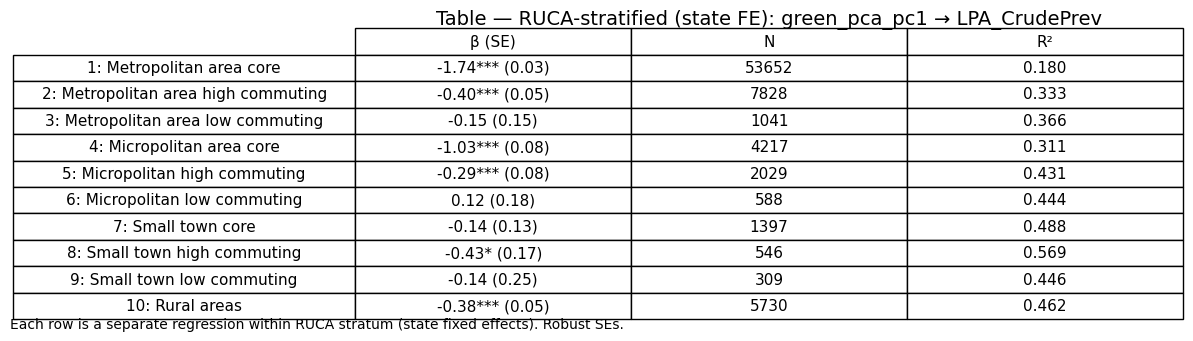

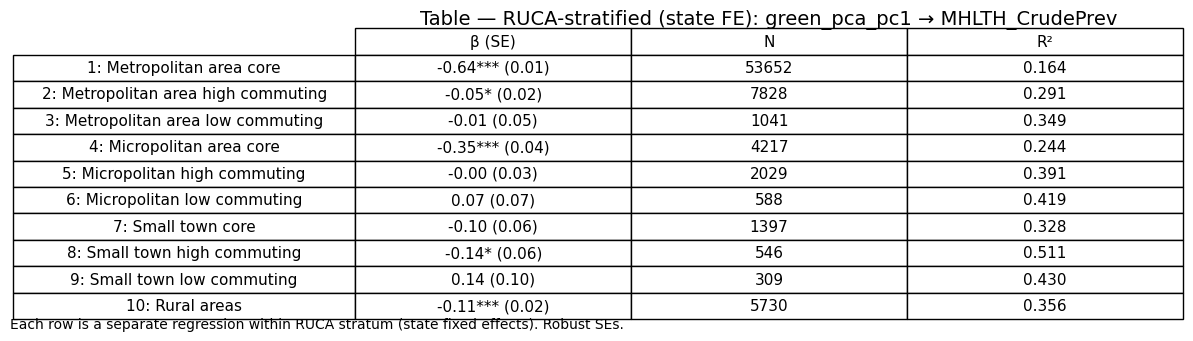

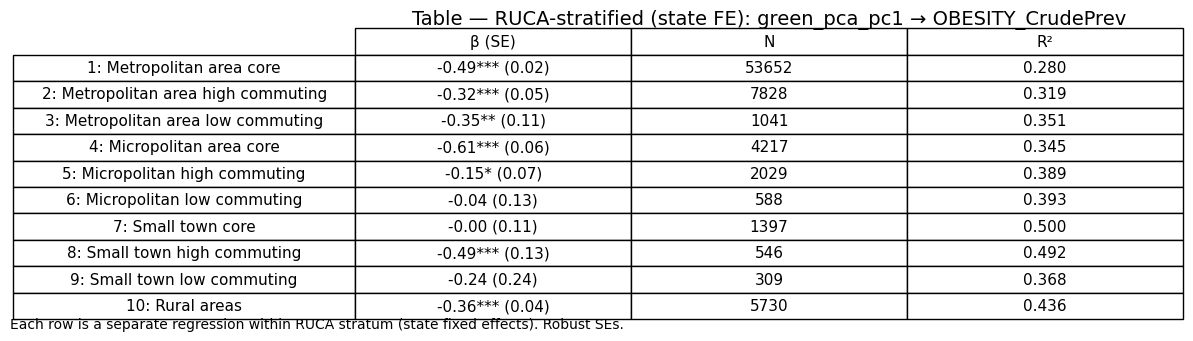

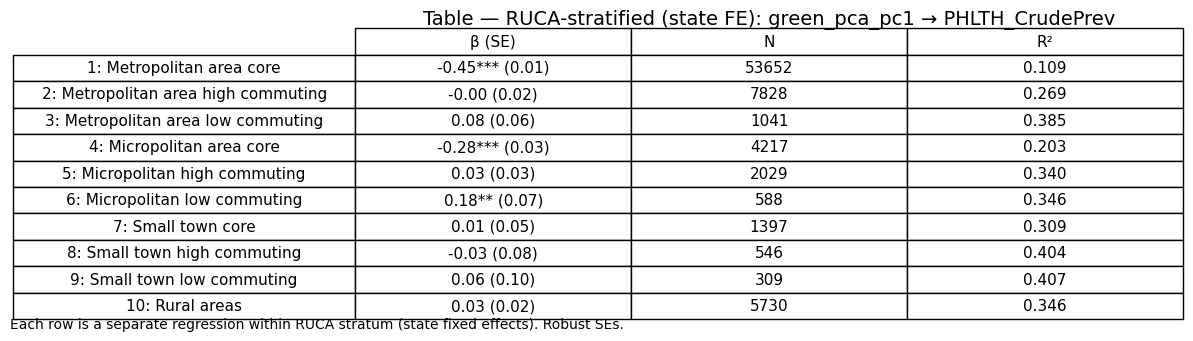

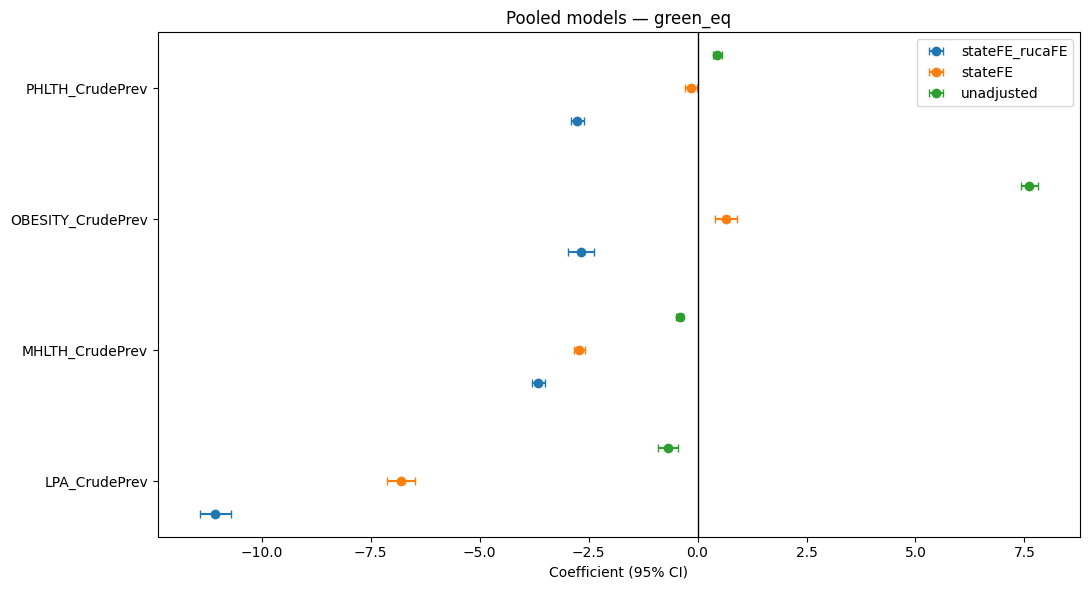

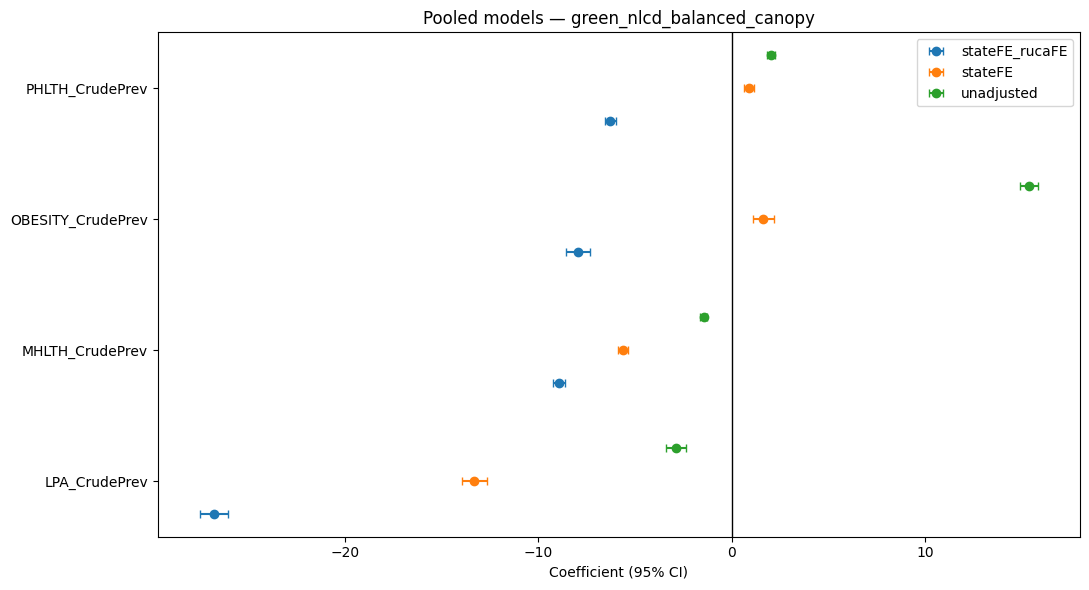

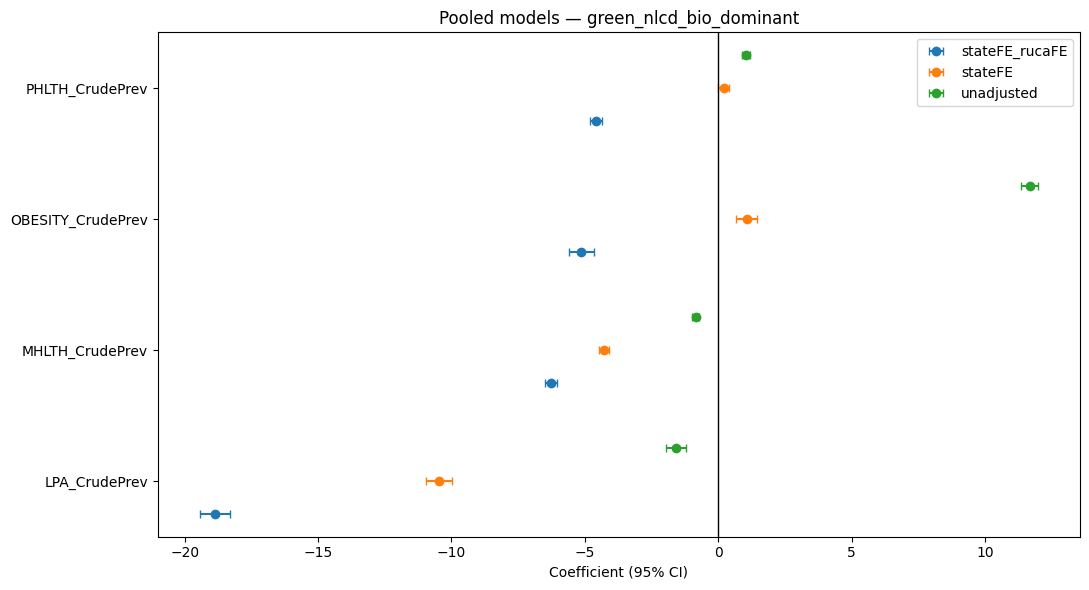

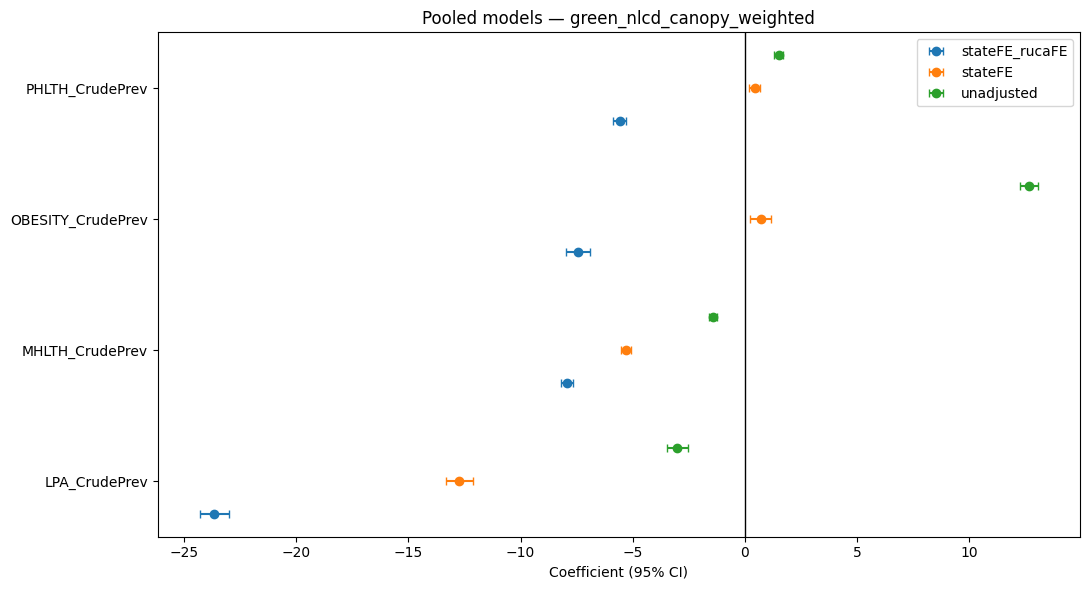

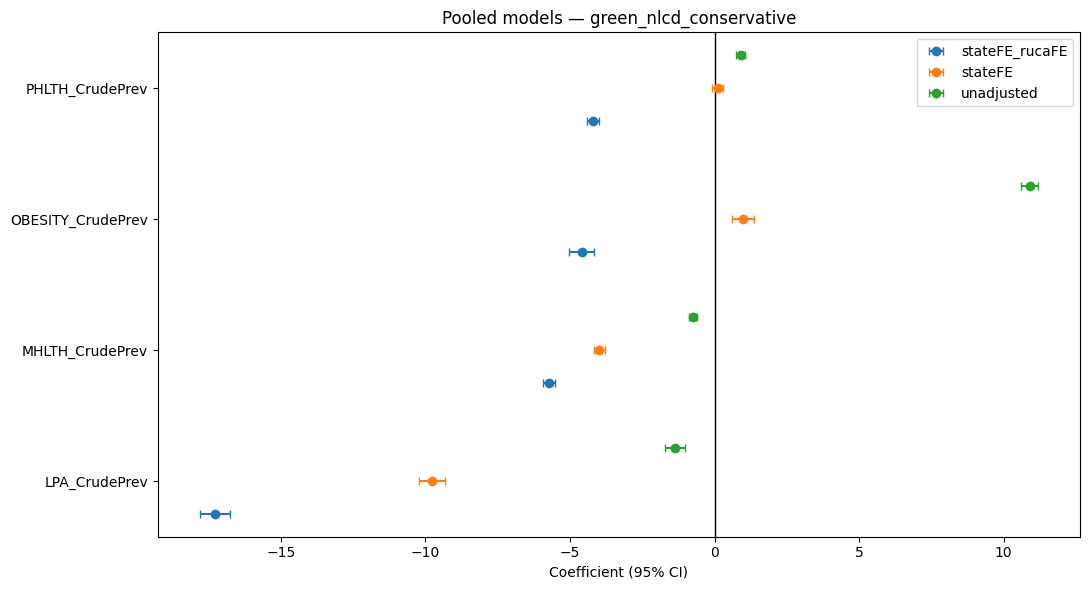

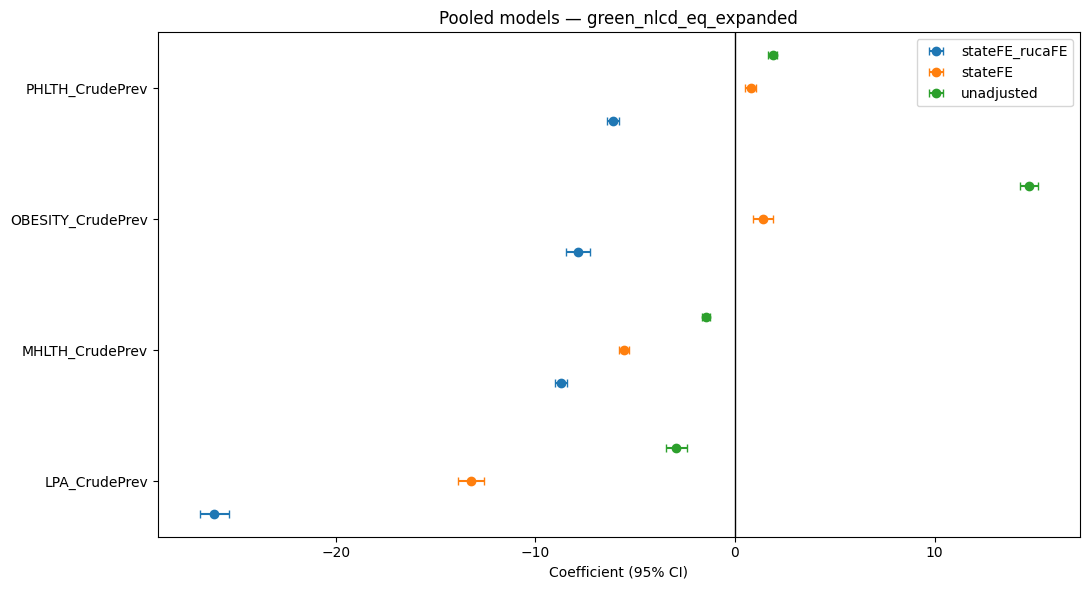

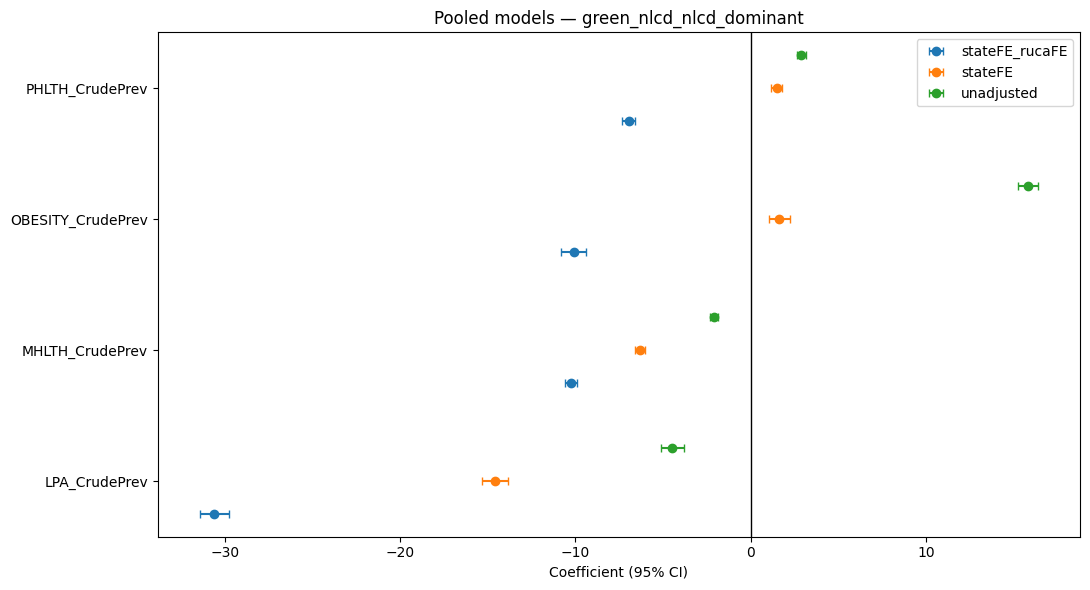

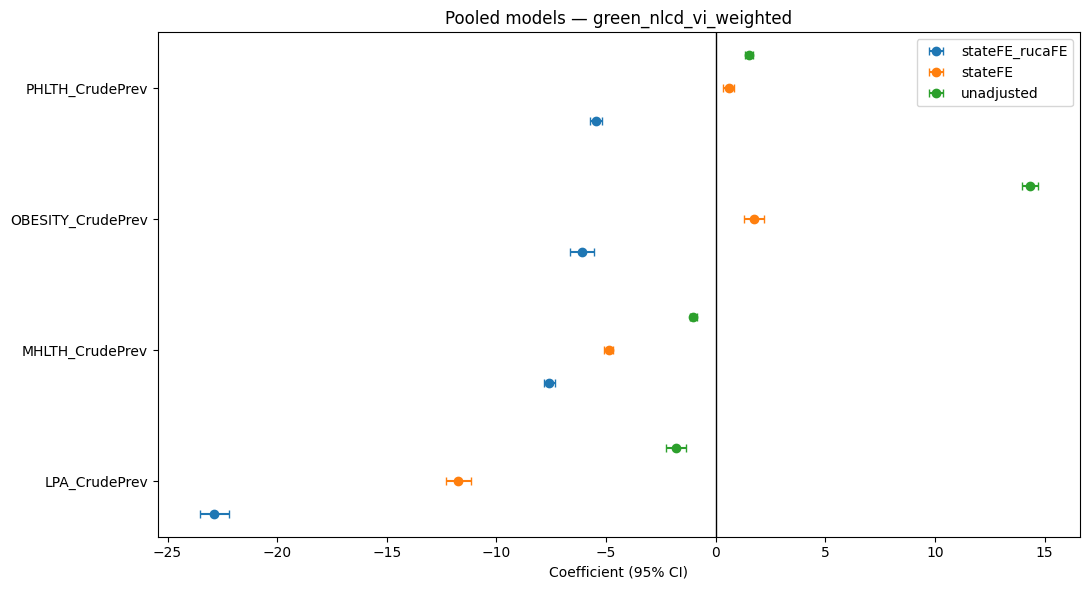

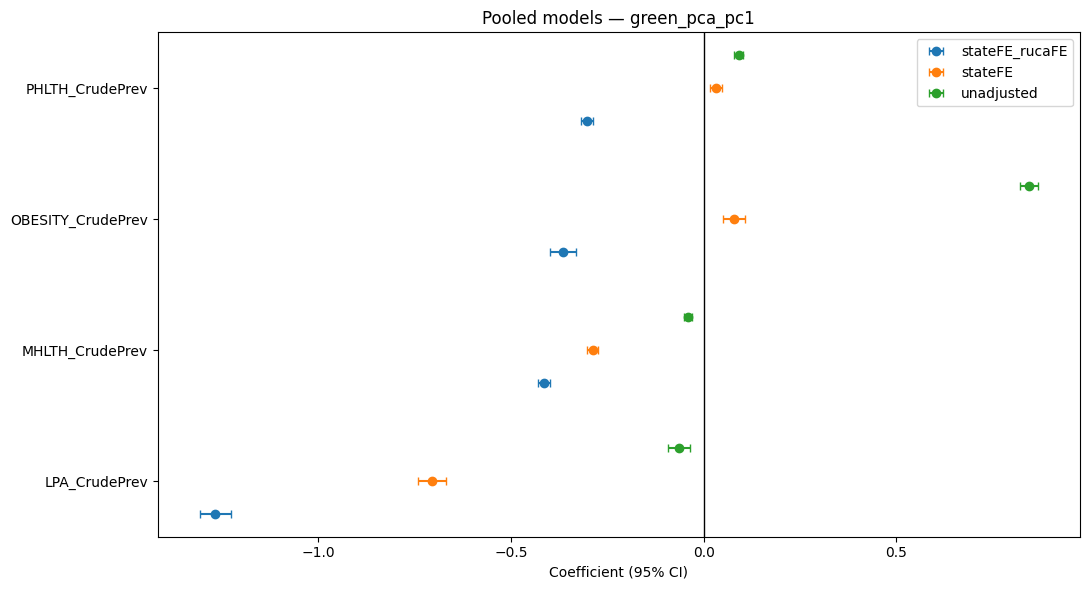

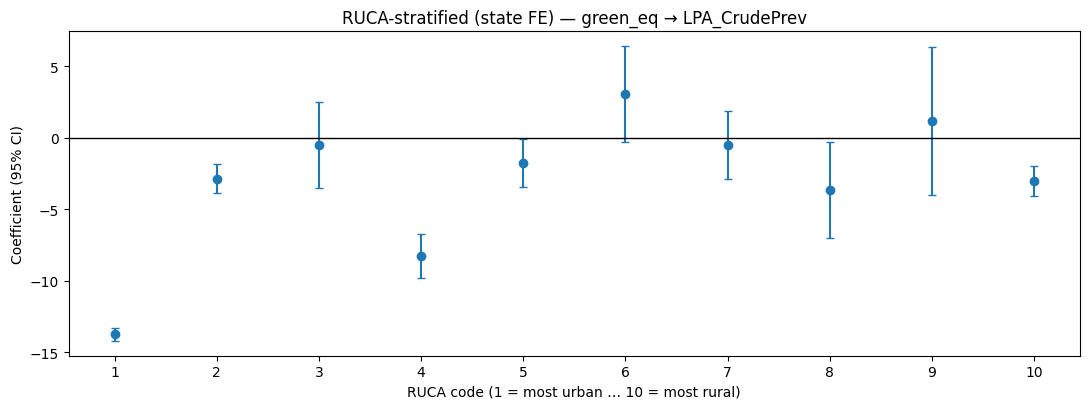

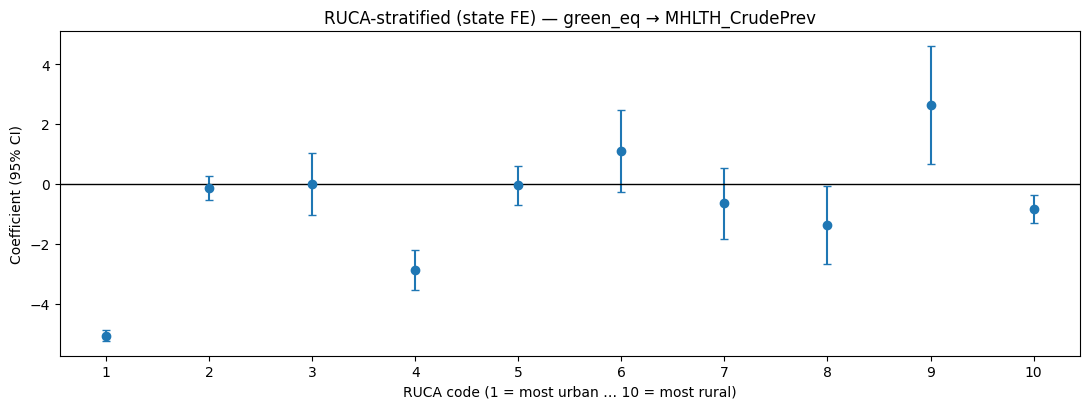

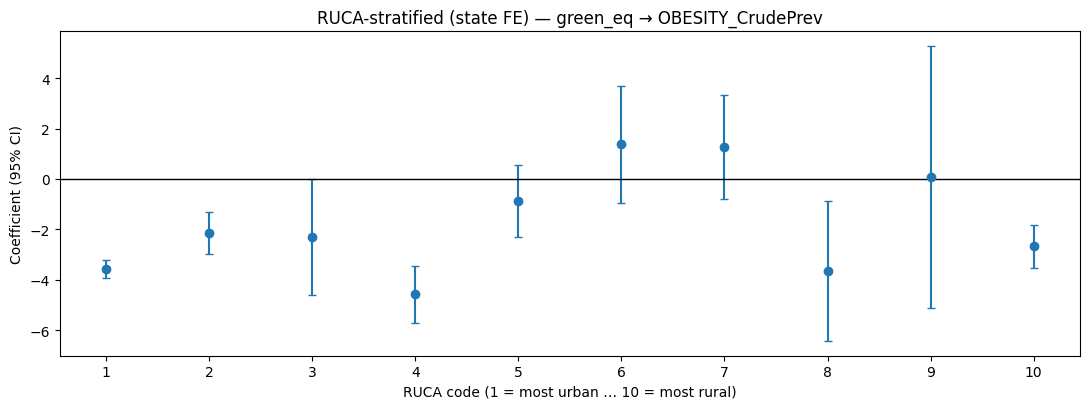

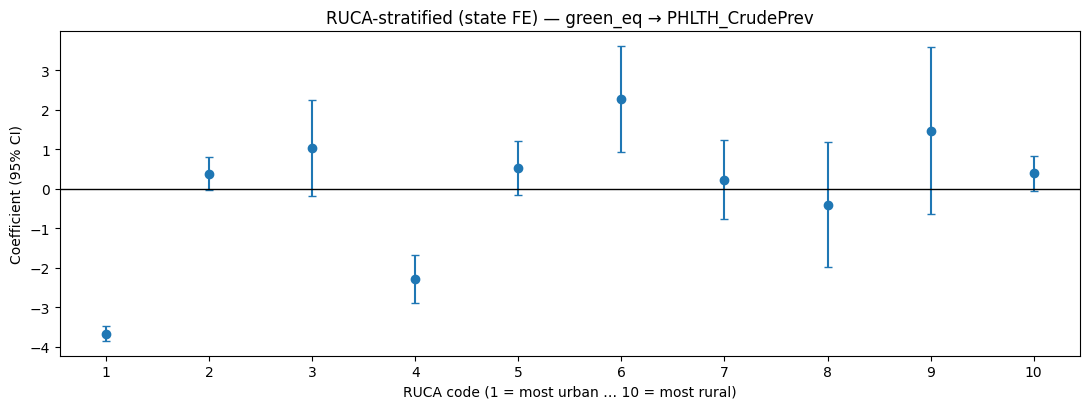

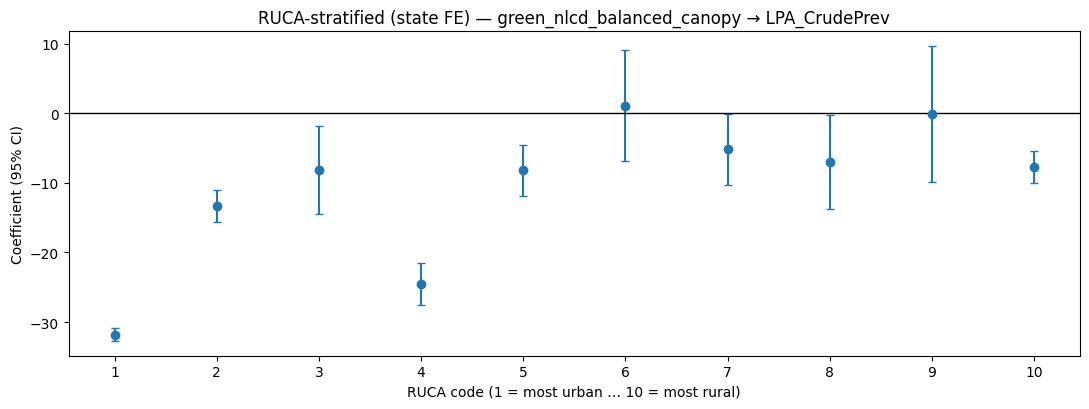

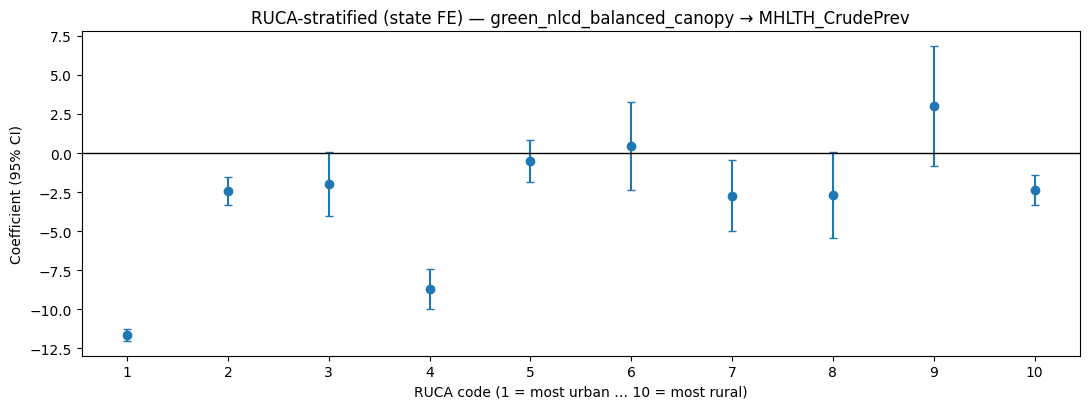

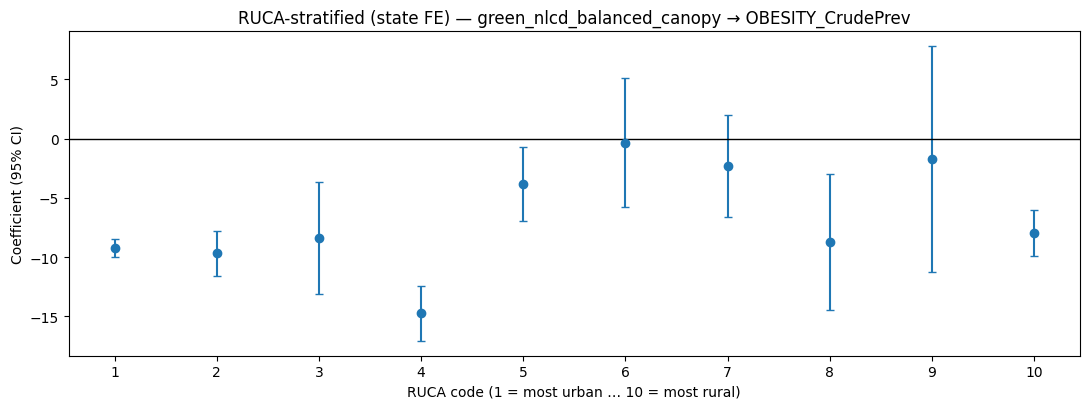

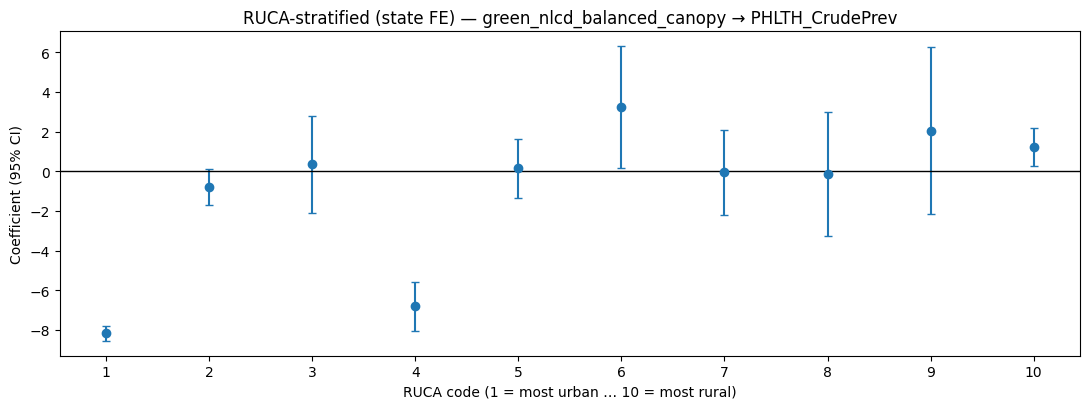

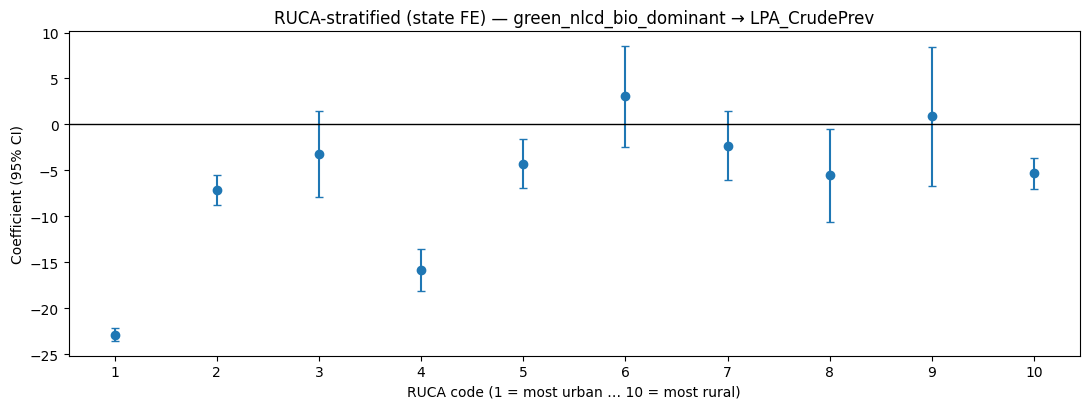

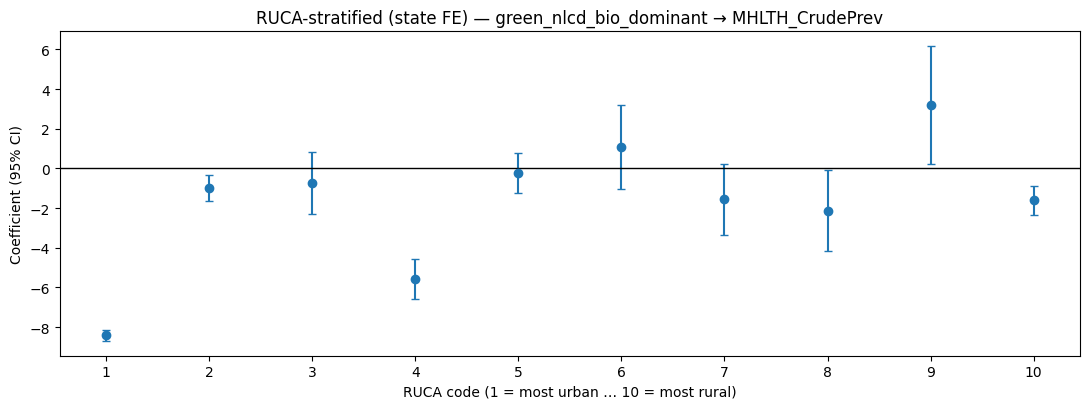

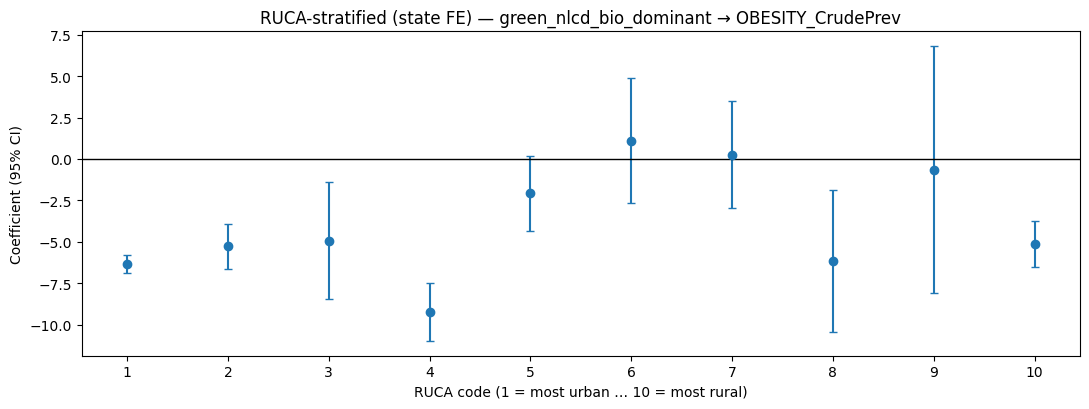

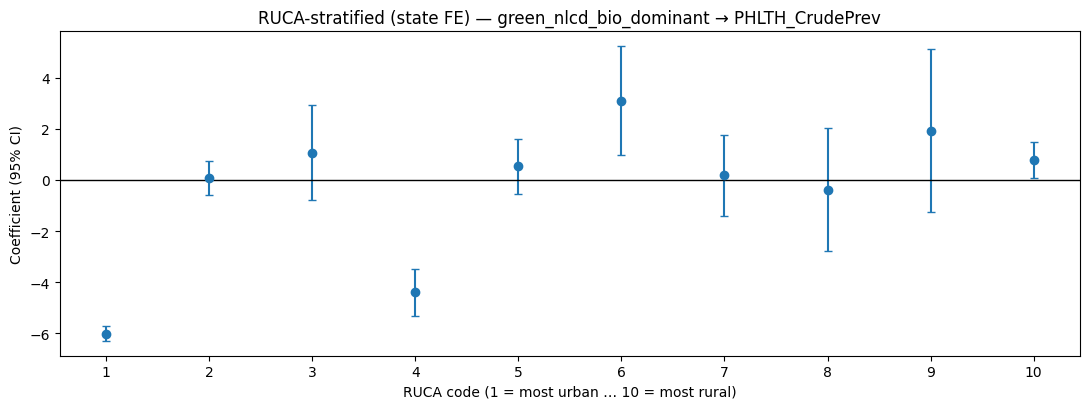

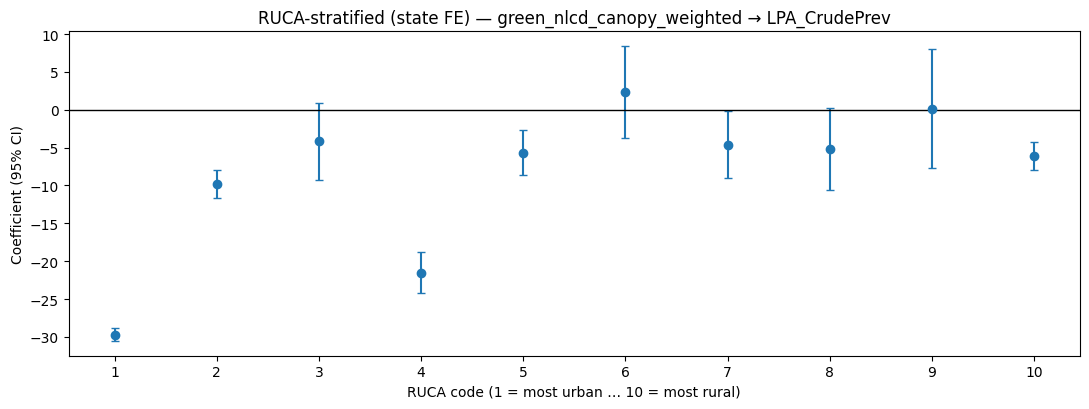

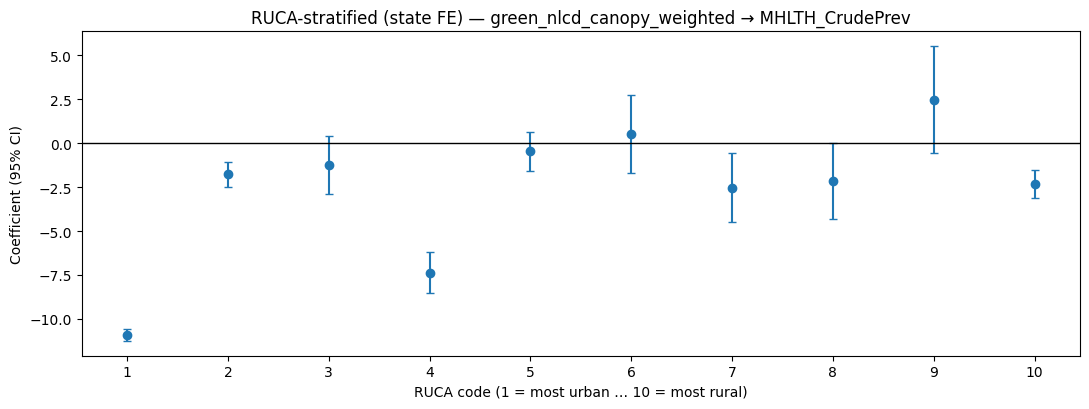

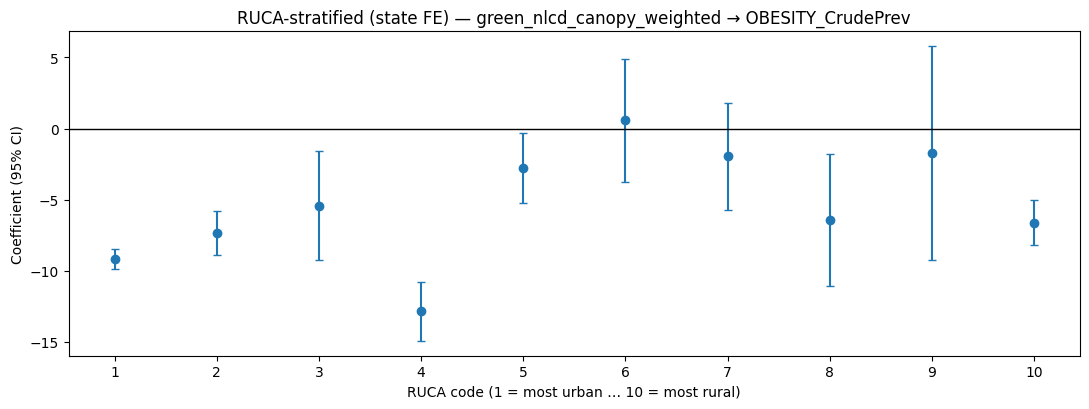

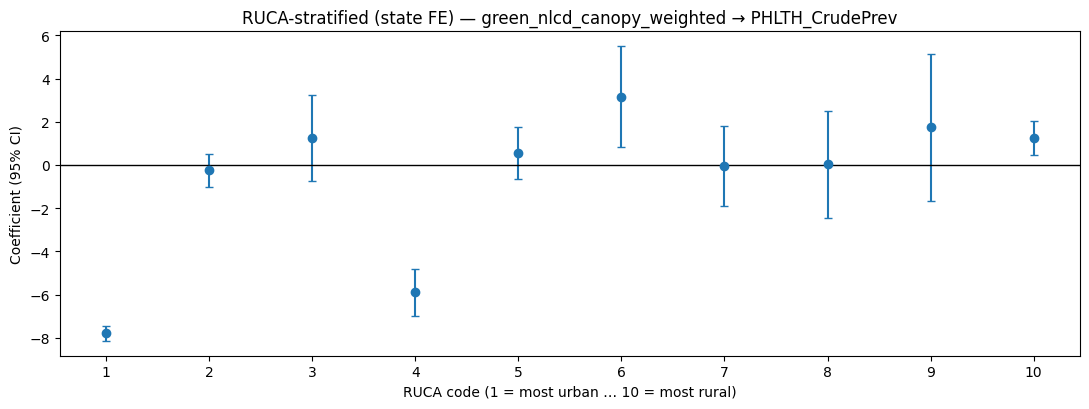

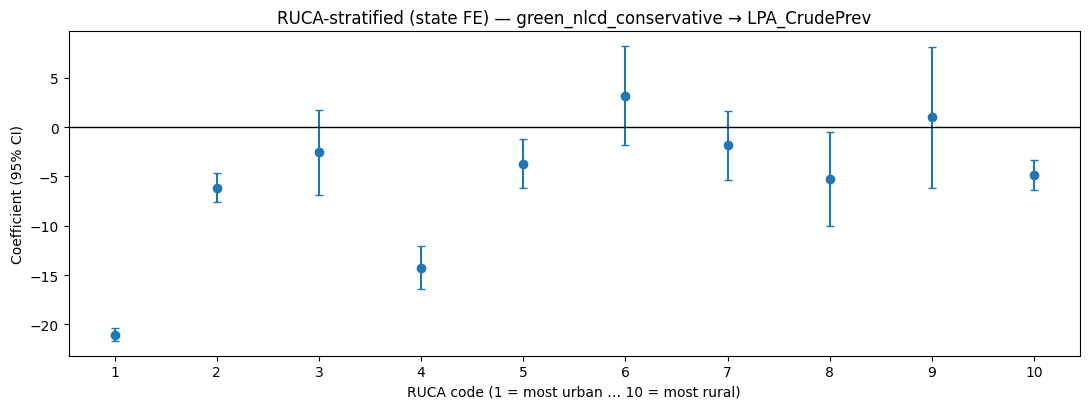

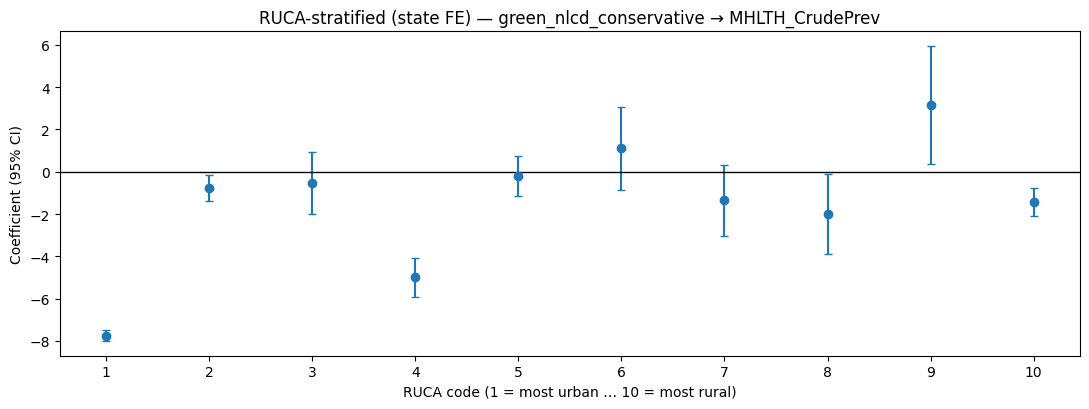

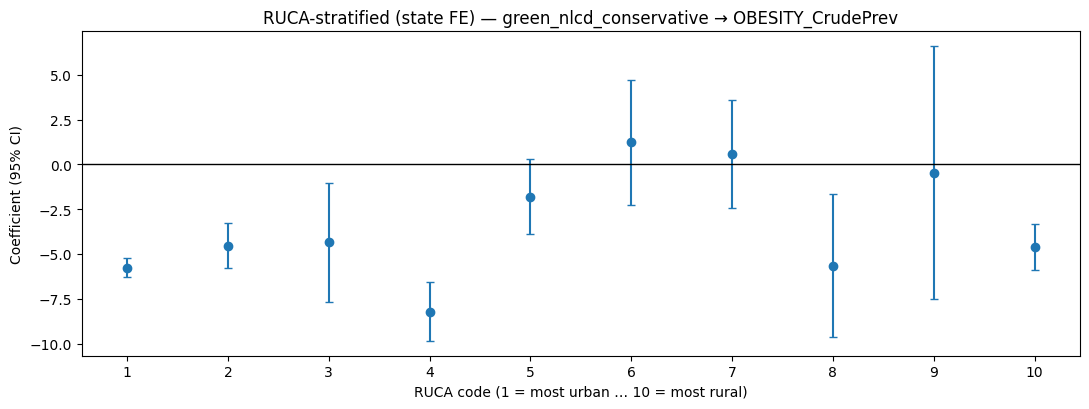

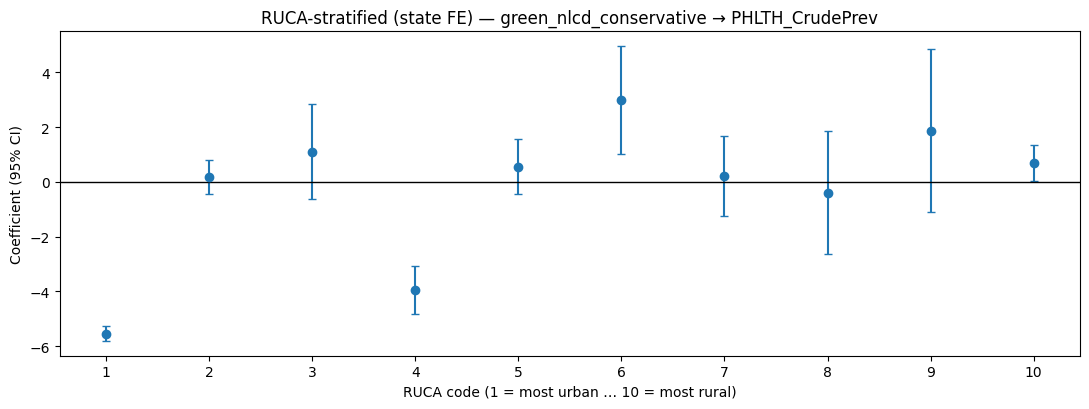

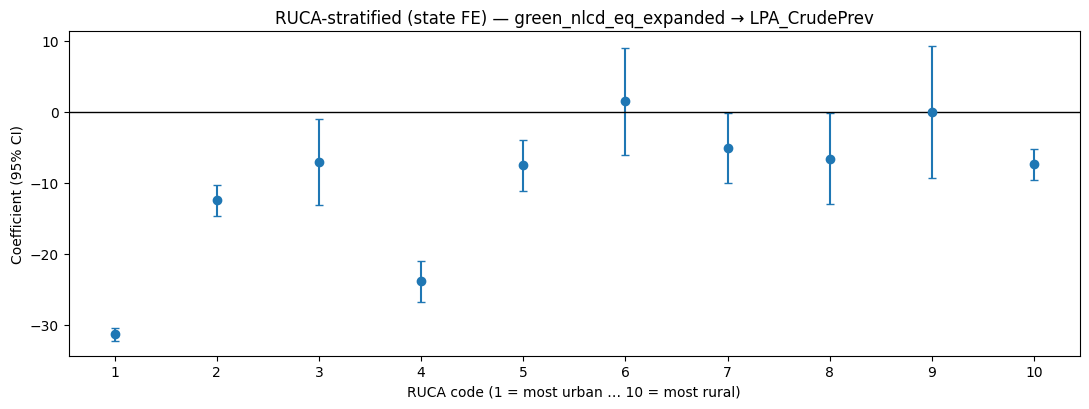

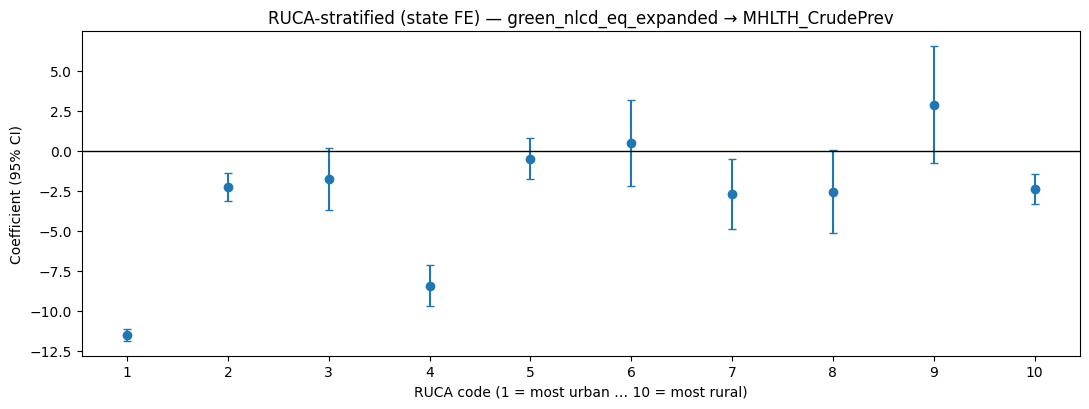

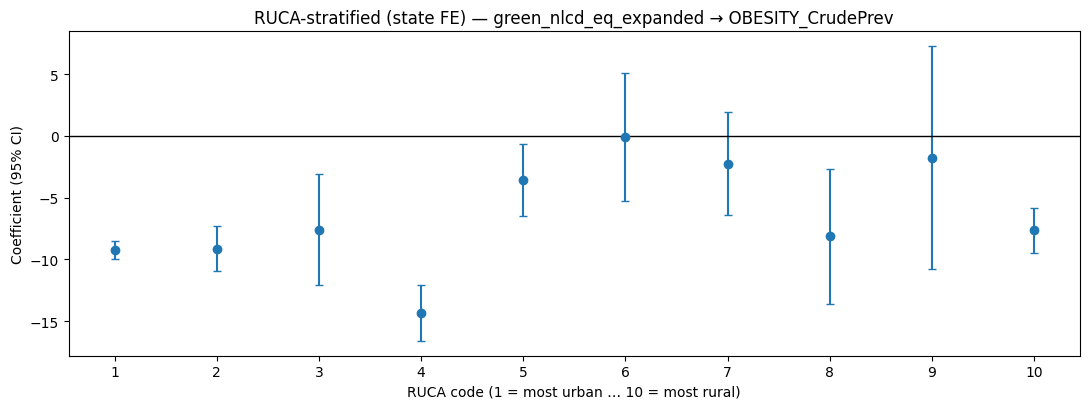

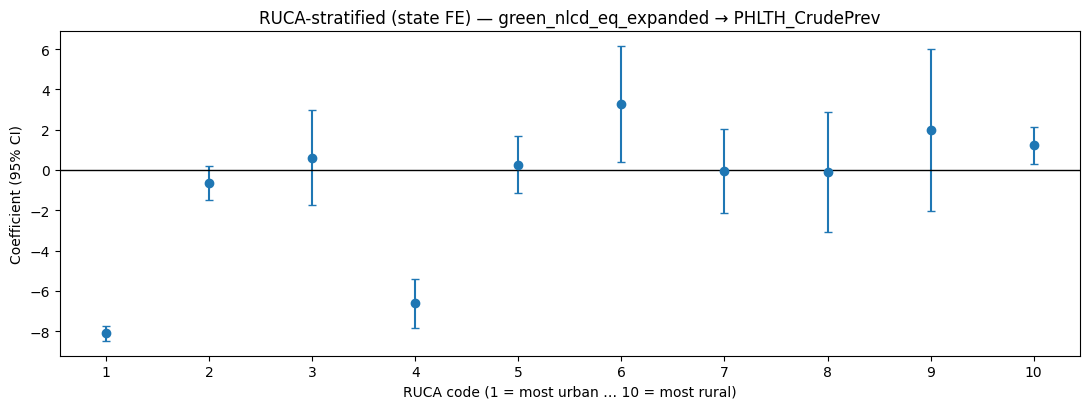

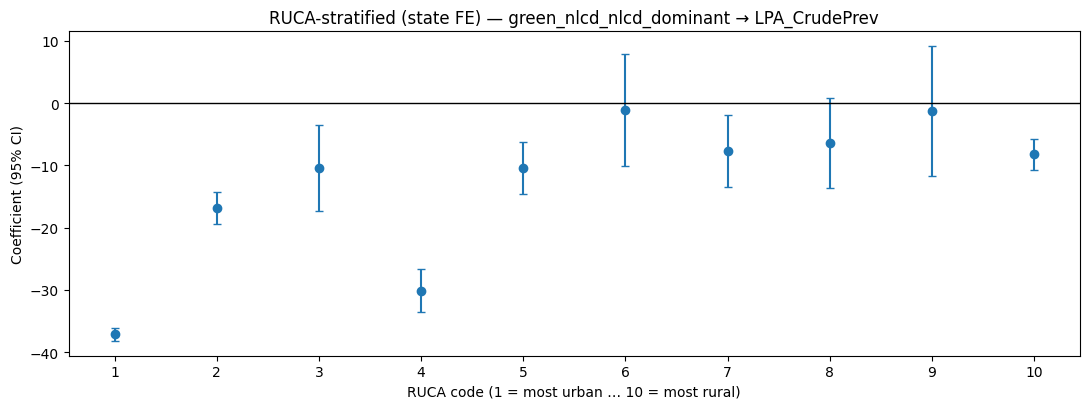

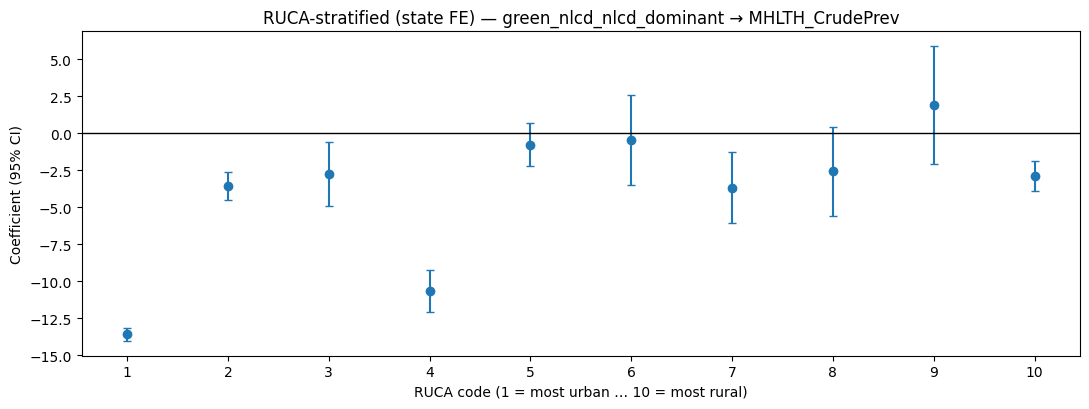

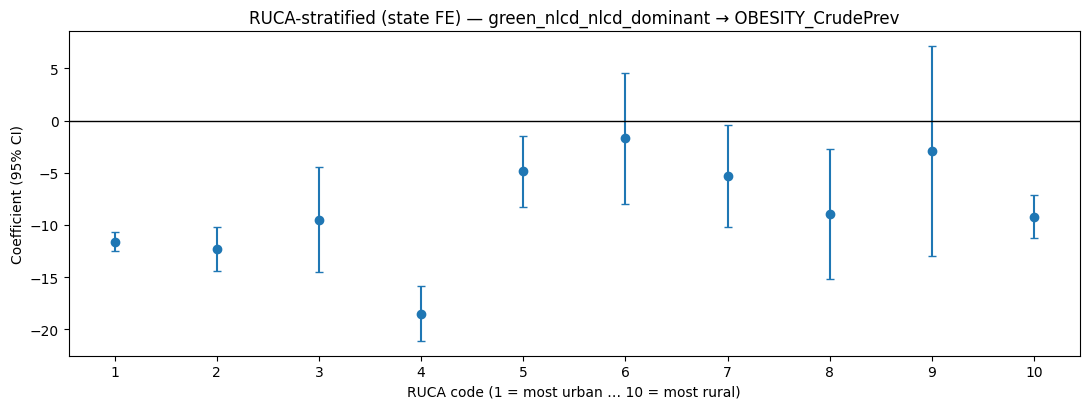

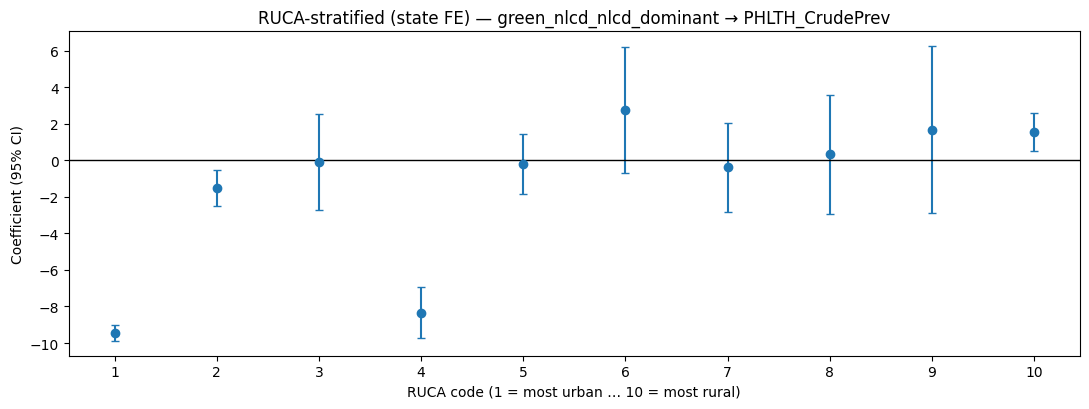

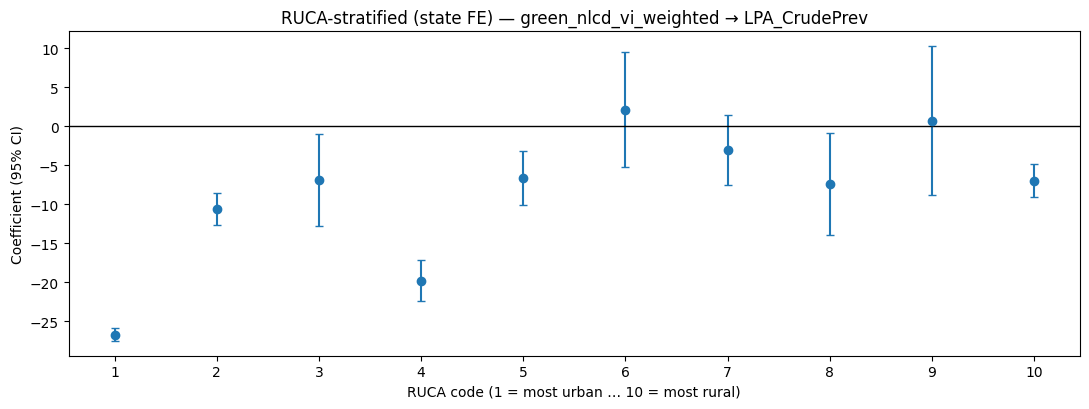

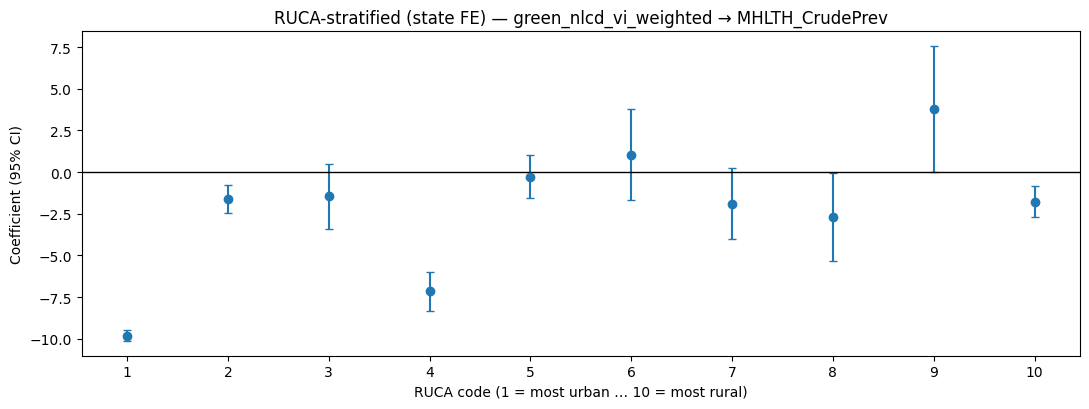

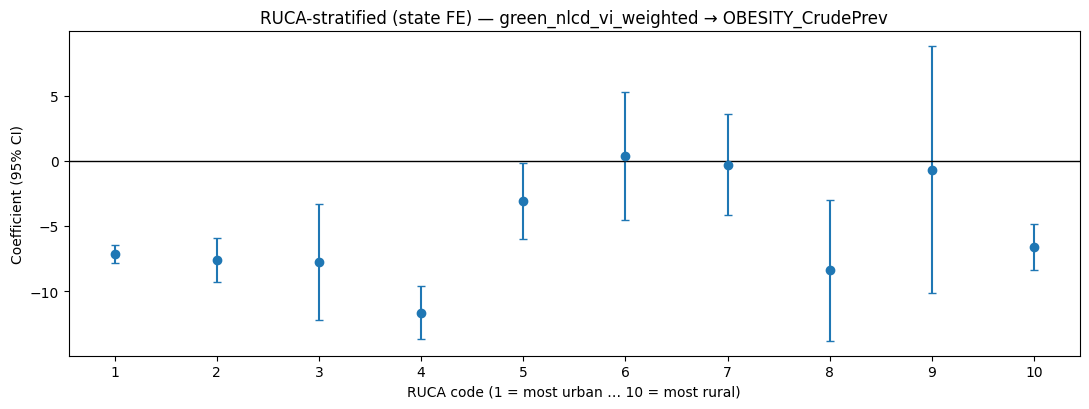

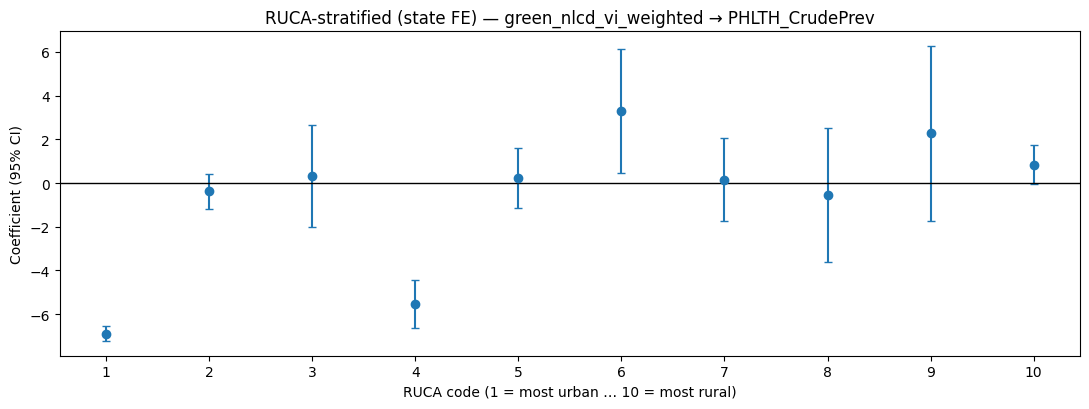

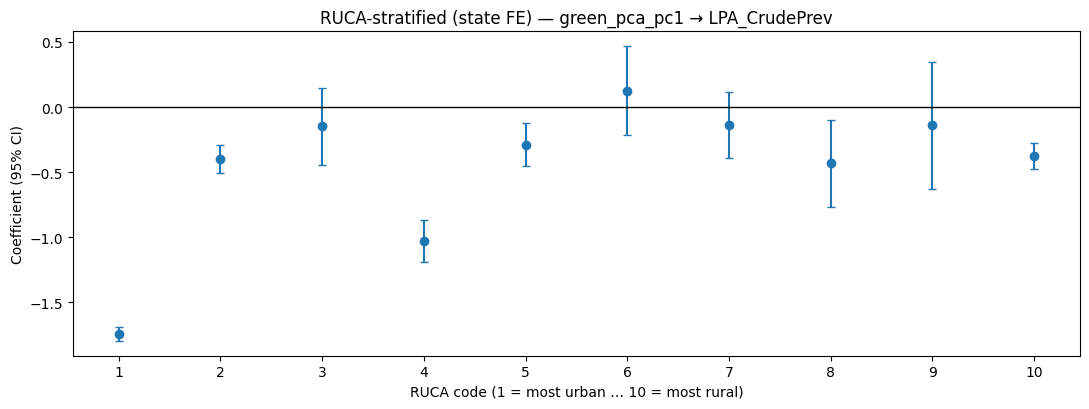

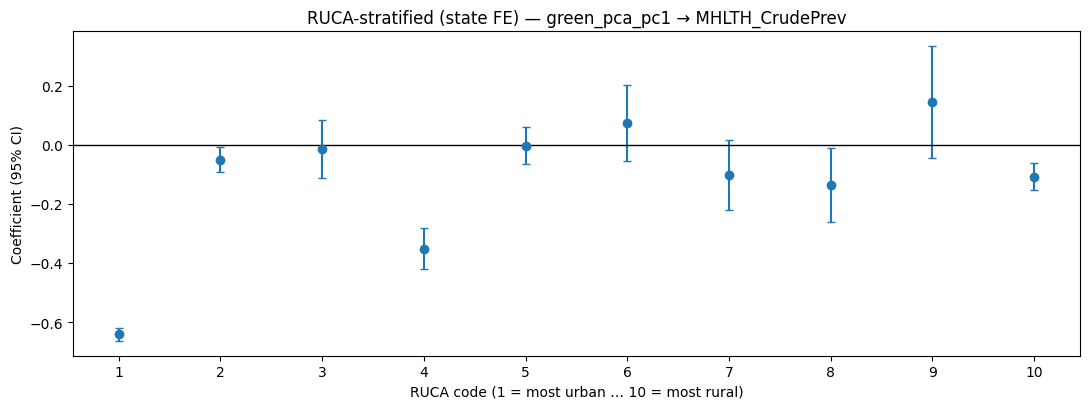

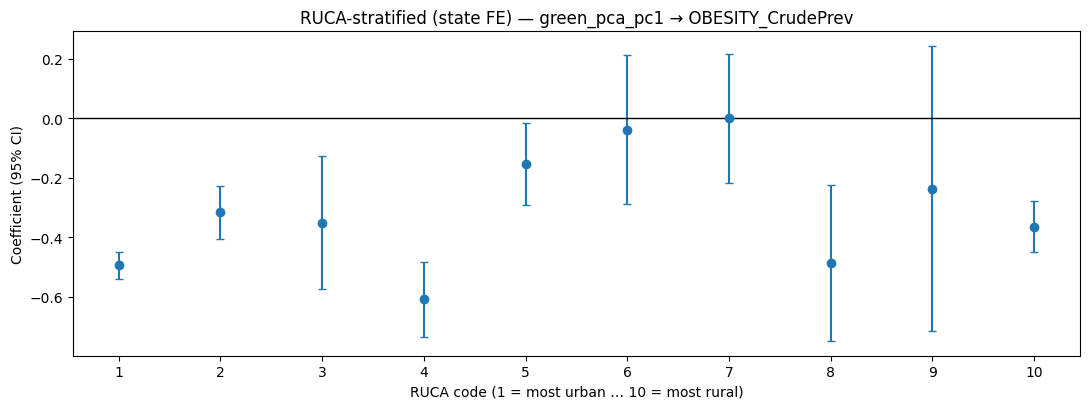

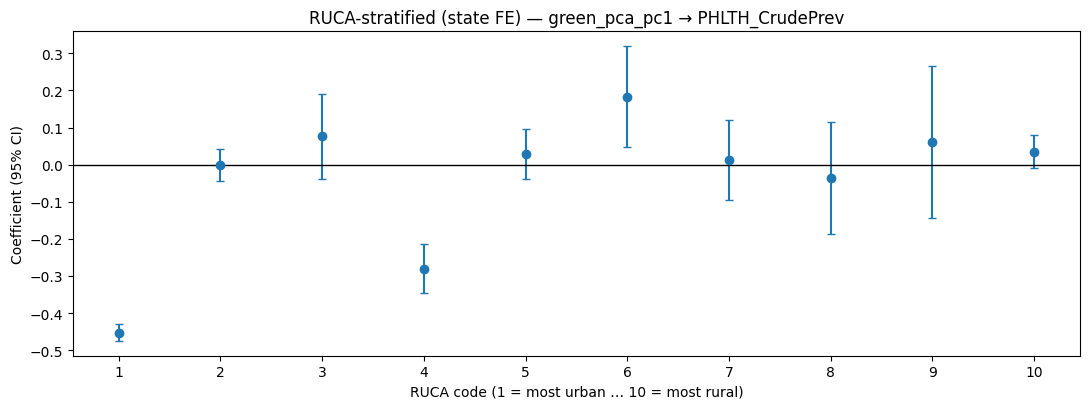

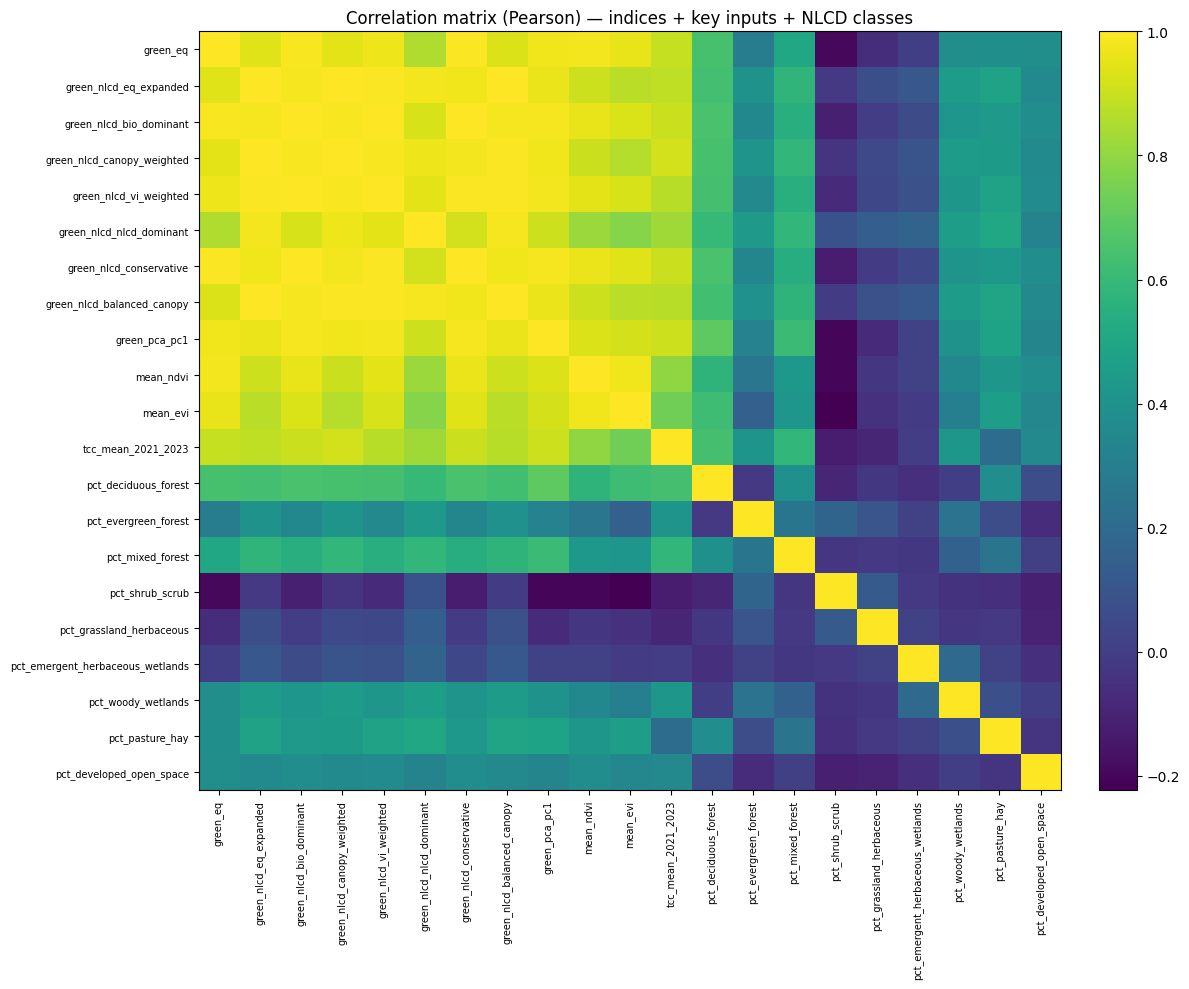


Done.


In [7]:
#!/usr/bin/env python3
# ------------------------------------------------------------
# purpose: Generate tables + figures + correlation matrix for
#          ALL indices + ALL model types from validation outputs.
# notes:
#   - Reads regression results from places_validation_results_with_ruca.csv
#   - Reads tract-level merged data from tract_indices_merged_with_ruca.csv for correlations
#   - Default: SHOW only (no files written). Set SAVE=True to export PNG/CSV.
# ------------------------------------------------------------

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================

ROOT = Path("/mnt/sda-21.8/bdevoe/greenspace")

RESULTS_FILE = ROOT / "processed" / "index_validation" / "places_validation_results_with_ruca.csv"
MERGED_FILE  = ROOT / "processed" / "index_validation" / "tract_indices_merged_with_ruca.csv"

# Output directory (only used if SAVE=True)
OUT_DIR = ROOT / "figures" / "index_validation" / "all_models"
OUT_DIR.mkdir(parents=True, exist_ok=True)

SAVE = False     # <---- set True to save PNGs/CSVs
DPI  = 220

# Outcomes to include in tables/plots
OUTCOMES = [
    "LPA_CrudePrev",
    "MHLTH_CrudePrev",
    "OBESITY_CrudePrev",
    "PHLTH_CrudePrev",
]

# Model sets
POOLED_MODELS = ["pooled_stateFE_rucaFE", "pooled_stateFE", "pooled_unadjusted"]  # show strongest first
STRAT_MODEL = "ruca_strat_stateFE"

# Which indices to include. If None -> auto-detect all "green_" in results.
INDICES_TO_INCLUDE = None  # e.g. ["green_eq","green_pca_pc1","green_nlcd_canopy_weighted"]

# Correlation set: include key inputs + NLCD classes + indices
CORR_EXTRA_COLS = [
    "mean_ndvi", "mean_evi", "tcc_mean_2021_2023",   # adjust if your merged file uses slightly different names
]
# If these aren't present, script will just skip them.

# RUCA descriptions (Primary RUCA)
RUCA_DESC = {
    1:  "Metropolitan area core",
    2:  "Metropolitan area high commuting",
    3:  "Metropolitan area low commuting",
    4:  "Micropolitan area core",
    5:  "Micropolitan high commuting",
    6:  "Micropolitan low commuting",
    7:  "Small town core",
    8:  "Small town high commuting",
    9:  "Small town low commuting",
    10: "Rural areas",
}

# ============================================================
# Helpers
# ============================================================

def stars(p):
    if pd.isna(p):
        return ""
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return ""

def fmt_coef_se(beta, se, p, nd=2):
    if pd.isna(beta) or pd.isna(se):
        return ""
    return f"{beta:.{nd}f}{stars(p)} ({se:.{nd}f})"

def add_ci(d):
    d = d.copy()
    d["ci_low"]  = d["estimate"] - 1.96 * d["std_error"]
    d["ci_high"] = d["estimate"] + 1.96 * d["std_error"]
    return d

def show_or_save(fig, fname=None):
    plt.tight_layout()
    if SAVE and fname:
        outpath = OUT_DIR / fname
        fig.savefig(outpath, dpi=DPI, bbox_inches="tight")
        print("Saved:", outpath)
        plt.close(fig)
    else:
        plt.show()

def draw_table_as_figure(cell_text, row_labels, col_labels, title, footnote=None, fname=None, fontsize=12):
    fig, ax = plt.subplots(figsize=(12, 3.4))
    ax.axis("off")

    tbl = ax.table(
        cellText=cell_text,
        rowLabels=row_labels,
        colLabels=col_labels,
        cellLoc="center",
        rowLoc="center",
        loc="center",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(fontsize)
    tbl.scale(1.0, 1.6)

    ax.set_title(title, fontsize=14, pad=14)

    if footnote:
        fig.text(0.01, 0.01, footnote, ha="left", va="bottom", fontsize=10)

    show_or_save(fig, fname=fname)


# ============================================================
# Load inputs
# ============================================================

if not RESULTS_FILE.exists():
    raise FileNotFoundError(f"Missing: {RESULTS_FILE}")

res = pd.read_csv(RESULTS_FILE)

# detect indices
all_indices = sorted(res["index"].dropna().unique().tolist())
if INDICES_TO_INCLUDE is None:
    indices = [i for i in all_indices if str(i).startswith("green_")]
else:
    indices = INDICES_TO_INCLUDE

print(f"Loaded results rows: {len(res):,}")
print(f"Detected indices: {len(indices)}")
print("Example indices:", indices[:10])

# ============================================================
# A) TABLES — pooled models for each index (Table 1 style)
# ============================================================

for idx in indices:
    d = res[
        (res["index"] == idx) &
        (res["model"].isin(POOLED_MODELS)) &
        (res["outcome"].isin(OUTCOMES))
    ].copy()

    if d.empty:
        continue

    # ensure order
    d["model"] = pd.Categorical(d["model"], POOLED_MODELS, ordered=True)

    # build table cells: rows=outcomes, cols=models
    cell = []
    for outcome in OUTCOMES:
        row = []
        for model in POOLED_MODELS:
            dm = d[(d["outcome"] == outcome) & (d["model"] == model)]
            if dm.empty:
                row.append("")
            else:
                row.append(fmt_coef_se(
                    dm["estimate"].iloc[0],
                    dm["std_error"].iloc[0],
                    dm["p"].iloc[0],
                    nd=2
                ))
        cell.append(row)

    col_labels = ["State + RUCA FE", "State FE", "Unadjusted"]
    title = f"Table — Greenspace validation (pooled models): {idx}"
    foot = "β (robust SE). Significance: * p<0.05, ** p<0.01, *** p<0.001."

    fname = f"table_pooled__{idx}.png" if SAVE else None
    draw_table_as_figure(cell, OUTCOMES, col_labels, title, footnote=foot, fname=fname, fontsize=12)

# ============================================================
# B) TABLES — RUCA stratified (state FE within RUCA), per index/outcome
# ============================================================

for idx in indices:
    for outcome in OUTCOMES:
        d = res[
            (res["index"] == idx) &
            (res["model"] == STRAT_MODEL) &
            (res["outcome"] == outcome)
        ].copy()

        if d.empty:
            continue

        d = d.dropna(subset=["ruca_level"]).copy()
        d["ruca_level"] = d["ruca_level"].astype(int)
        d = d.sort_values("ruca_level")

        # rows = RUCA 1..10, cols = coef(SE), n, r2
        row_labels = []
        cell = []
        for r in range(1, 11):
            dr = d[d["ruca_level"] == r]
            if dr.empty:
                continue
            row_labels.append(f"{r}: {RUCA_DESC.get(r,'')}")
            cell.append([
                fmt_coef_se(dr["estimate"].iloc[0], dr["std_error"].iloc[0], dr["p"].iloc[0], nd=2),
                f"{int(dr['n'].iloc[0])}",
                f"{dr['r2'].iloc[0]:.3f}"
            ])

        if not cell:
            continue

        col_labels = ["β (SE)", "N", "R²"]
        title = f"Table — RUCA-stratified (state FE): {idx} → {outcome}"
        foot = "Each row is a separate regression within RUCA stratum (state fixed effects). Robust SEs."

        fname = f"table_ruca_strat__{idx}__{outcome}.png" if SAVE else None
        draw_table_as_figure(cell, row_labels, col_labels, title, footnote=foot, fname=fname, fontsize=11)

# ============================================================
# C) FIGURES — pooled coefficient dotplots (per index)
# ============================================================

for idx in indices:
    d = res[
        (res["index"] == idx) &
        (res["model"].isin(POOLED_MODELS)) &
        (res["outcome"].isin(OUTCOMES))
    ].copy()
    if d.empty:
        continue

    d = add_ci(d)
    d["model"] = pd.Categorical(d["model"], POOLED_MODELS, ordered=True)

    fig, ax = plt.subplots(figsize=(11, 6))

    y_map = {o: i for i, o in enumerate(OUTCOMES)}
    offsets = np.linspace(-0.25, 0.25, len(POOLED_MODELS))

    for j, m in enumerate(POOLED_MODELS):
        dm = d[d["model"] == m]
        if dm.empty:
            continue
        y = np.array([y_map[o] for o in dm["outcome"]]) + offsets[j]

        ax.errorbar(
            dm["estimate"],
            y,
            xerr=[dm["estimate"] - dm["ci_low"], dm["ci_high"] - dm["estimate"]],
            fmt="o",
            capsize=3,
            label=m.replace("pooled_", "")
        )

    ax.axvline(0, color="black", linewidth=1)
    ax.set_yticks(list(y_map.values()))
    ax.set_yticklabels(OUTCOMES)
    ax.set_xlabel("Coefficient (95% CI)")
    ax.set_title(f"Pooled models — {idx}")
    ax.legend(loc="best")

    fname = f"fig_pooled__{idx}.png" if SAVE else None
    show_or_save(fig, fname=fname)

# ============================================================
# D) FIGURES — RUCA stratified coefficient plots (per index/outcome)
# ============================================================

for idx in indices:
    for outcome in OUTCOMES:
        d = res[
            (res["index"] == idx) &
            (res["model"] == STRAT_MODEL) &
            (res["outcome"] == outcome)
        ].copy()
        if d.empty:
            continue

        d = add_ci(d)
        d = d.dropna(subset=["ruca_level"]).copy()
        d["ruca_level"] = d["ruca_level"].astype(int)
        d = d.sort_values("ruca_level")

        fig, ax = plt.subplots(figsize=(11, 4.2))

        ax.errorbar(
            d["ruca_level"],
            d["estimate"],
            yerr=[d["estimate"] - d["ci_low"], d["ci_high"] - d["estimate"]],
            fmt="o",
            capsize=3
        )
        ax.axhline(0, color="black", linewidth=1)
        ax.set_xticks(range(1, 11))
        ax.set_xlabel("RUCA code (1 = most urban … 10 = most rural)")
        ax.set_ylabel("Coefficient (95% CI)")
        ax.set_title(f"RUCA-stratified (state FE) — {idx} → {outcome}")

        fname = f"fig_ruca_strat__{idx}__{outcome}.png" if SAVE else None
        show_or_save(fig, fname=fname)

# ============================================================
# E) CORRELATION MATRIX — indices + key NLCD classes + inputs
# ============================================================

if MERGED_FILE.exists():
    dat = pd.read_csv(MERGED_FILE)

    # columns to correlate: all green_* + any pct_* NLCD + selected extras if present
    green_cols = [c for c in dat.columns if c.startswith("green_")]
    nlcd_cols  = [c for c in dat.columns if c.startswith("pct_")]  # your NLCD-readable file produces pct_*
    extra_cols = [c for c in CORR_EXTRA_COLS if c in dat.columns]

    corr_cols = green_cols + extra_cols + nlcd_cols
    corr_cols = [c for c in corr_cols if c in dat.columns]

    # keep reasonable size: if too many NLCD classes, keep only the ones used in indices (heuristic)
    # If you want ALL, comment this block out.
    if len(nlcd_cols) > 30:
        keep_keywords = [
            "deciduous", "evergreen", "mixed",
            "woody_wetlands", "emergent_herbaceous_wetlands",
            "grassland", "shrub", "pasture",
            "developed_open_space"
        ]
        nlcd_keep = [c for c in nlcd_cols if any(k in c for k in keep_keywords)]
        corr_cols = green_cols + extra_cols + nlcd_keep

    corr_df = dat[corr_cols].apply(pd.to_numeric, errors="coerce")
    corr_mat = corr_df.corr(method="pearson", min_periods=500)

    # plot matrix
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(corr_mat.values, aspect="auto")
    ax.set_title("Correlation matrix (Pearson) — indices + key inputs + NLCD classes")

    ax.set_xticks(range(len(corr_mat.columns)))
    ax.set_yticks(range(len(corr_mat.index)))
    ax.set_xticklabels(corr_mat.columns, rotation=90, fontsize=7)
    ax.set_yticklabels(corr_mat.index, fontsize=7)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

    fname = "fig_correlation_matrix.png" if SAVE else None
    show_or_save(fig, fname=fname)

    # optionally export matrix
    if SAVE:
        corr_out = OUT_DIR / "correlation_matrix.csv"
        corr_mat.to_csv(corr_out)
        print("Saved:", corr_out)

else:
    print(f"[WARN] merged file not found for correlations: {MERGED_FILE}")

print("\nDone.")


In [ ]:
# ============================================================
# Build ONE PDF with all figures + tables
# Uses matplotlib PdfPages (no reportlab)
# ============================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ---------------------------
# Paths
# ---------------------------
ROOT = Path("/mnt/sda-21.8/bdevoe/greenspace")
RESULTS = ROOT / "processed/index_validation/places_validation_results_with_ruca.csv"
MERGED  = ROOT / "processed/index_validation/tract_indices_merged_with_ruca.csv"

FIG_DIR = ROOT / "figures/index_validation"
FIG_DIR.mkdir(parents=True, exist_ok=True)

OUT_PDF = FIG_DIR / "greenspace_validation_all_models.pdf"

# ---------------------------
# Load data
# ---------------------------
res = pd.read_csv(RESULTS)
merged = pd.read_csv(MERGED)

# ---------------------------
# Config
# ---------------------------
INDICES = sorted(res["index"].unique())
OUTCOMES = ["LPA_CrudePrev", "MHLTH_CrudePrev", "OBESITY_CrudePrev", "PHLTH_CrudePrev"]

POOLED_MODELS = [
    "pooled_unadjusted",
    "pooled_stateFE",
    "pooled_stateFE_rucaFE"
]

MODEL_LABELS = {
    "pooled_unadjusted": "Unadjusted",
    "pooled_stateFE": "State FE",
    "pooled_stateFE_rucaFE": "State + RUCA FE",
}

STRAT_MODEL = "ruca_strat_stateFE"

# ---------------------------
# Helpers
# ---------------------------
def add_ci(df):
    d = df.copy()
    d["lo"] = d["estimate"] - 1.96 * d["std_error"]
    d["hi"] = d["estimate"] + 1.96 * d["std_error"]
    return d

def stars(p):
    return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

# ============================================================
# Build PDF
# ============================================================
with PdfPages(OUT_PDF) as pdf:

    # -----------------------
    # Cover page
    # -----------------------
    fig, ax = plt.subplots(figsize=(11, 8.5))
    ax.axis("off")
    ax.text(0.5, 0.65, "Greenspace Index Validation",
            ha="center", va="center", fontsize=22, weight="bold")
    ax.text(0.5, 0.55,
            "All indices × all model specifications\n(unadjusted, state FE, RUCA FE, RUCA-stratified)",
            ha="center", va="center", fontsize=14)
    pdf.savefig(fig)
    plt.close(fig)

    # ========================================================
    # 1) POOLED COEFFICIENT FIGURES
    # ========================================================
    for idx in INDICES:
        d = res[
            (res["index"] == idx) &
            (res["model"].isin(POOLED_MODELS)) &
            (res["outcome"].isin(OUTCOMES))
        ]
        if d.empty:
            continue

        d = add_ci(d)

        fig, ax = plt.subplots(figsize=(10, 6))
        y_map = {o: i for i, o in enumerate(OUTCOMES)}
        offsets = np.linspace(-0.25, 0.25, len(POOLED_MODELS))

        for j, m in enumerate(POOLED_MODELS):
            dm = d[d["model"] == m]
            y = np.array([y_map[o] for o in dm["outcome"]]) + offsets[j]
            ax.errorbar(
                dm["estimate"], y,
                xerr=[dm["estimate"] - dm["lo"], dm["hi"] - dm["estimate"]],
                fmt="o", capsize=3, label=MODEL_LABELS[m]
            )

        ax.axvline(0, color="black")
        ax.set_yticks(list(y_map.values()))
        ax.set_yticklabels(OUTCOMES)
        ax.set_xlabel("Coefficient (95% CI)")
        ax.set_title(f"Pooled models — {idx}")
        ax.legend()
        plt.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)

    # ========================================================
    # 2) RUCA-STRATIFIED FIGURES
    # ========================================================
    for idx in INDICES:
        for outcome in OUTCOMES:
            d = res[
                (res["index"] == idx) &
                (res["model"] == STRAT_MODEL) &
                (res["outcome"] == outcome)
            ]
            if d.empty:
                continue

            d = add_ci(d).dropna(subset=["ruca_level"])
            d = d.sort_values("ruca_level")

            fig, ax = plt.subplots(figsize=(10, 4))
            ax.errorbar(
                d["ruca_level"], d["estimate"],
                yerr=[d["estimate"] - d["lo"], d["hi"] - d["estimate"]],
                fmt="o", capsize=3
            )
            ax.axhline(0, color="black")
            ax.set_xticks(range(1, 11))
            ax.set_xlabel("RUCA (1 = urban → 10 = rural)")
            ax.set_ylabel("Coefficient")
            ax.set_title(f"{idx} → {outcome} (RUCA-stratified, state FE)")
            plt.tight_layout()

            pdf.savefig(fig)
            plt.close(fig)

    # ========================================================
    # 3) REGRESSION TABLES (β (SE))
    # ========================================================
    for idx in INDICES:
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.axis("off")

        table = pd.DataFrame(index=OUTCOMES, columns=MODEL_LABELS.values())

        for _, r in res[(res["index"] == idx) & (res["model"].isin(POOLED_MODELS))].iterrows():
            table.loc[r["outcome"], MODEL_LABELS[r["model"]]] = (
                f'{r["estimate"]:.2f}{stars(r["p"])} ({r["std_error"]:.2f})'
            )

        ax.table(
            cellText=table.values,
            rowLabels=table.index,
            colLabels=table.columns,
            loc="center",
            cellLoc="center"
        )
        ax.set_title(f"Regression results — {idx} (β (SE))", pad=15)

        pdf.savefig(fig)
        plt.close(fig)

    # ========================================================
    # 4) CORRELATION MATRIX
    # ========================================================
    corr_cols = [c for c in merged.columns if c.startswith("green_") or c.startswith("pct_")]
    corr = merged[corr_cols].corr()

    fig, ax = plt.subplots(figsize=(11, 9))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap="viridis")
    ax.set_xticks(range(len(corr_cols)))
    ax.set_yticks(range(len(corr_cols)))
    ax.set_xticklabels(corr_cols, rotation=90, fontsize=7)
    ax.set_yticklabels(corr_cols, fontsize=7)
    ax.set_title("Correlation matrix — indices and NLCD classes")
    fig.colorbar(im, ax=ax)
    plt.tight_layout()

    pdf.savefig(fig)
    plt.close(fig)

print(f"\n✅ Saved combined PDF to:\n{OUT_PDF}")
